In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import TensorDataset, DataLoader
import wandb
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import re
import seaborn as sns

In [ ]:
train_data = torch.load("train_data.pt")  
train_labels = torch.load("train_labels.pt")
test_data = torch.load("test_data.pt")
test_labels = torch.load("test_labels.pt")
train_data = train_data.float() 
test_data = test_data.float() 
batch_size = 500
train_ds = TensorDataset(train_data, train_labels)
test_ds = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)
num_classes = len(torch.unique(train_labels))
print(f"Number of classes: {num_classes}")

Number of classes: 10


/var/folders/vm/wmkh255j12x_ylgv2g4ltlhr0000gn/T/ipykernel_76332/1256962000.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load("train_data.pt")
/var

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-3):
    device = next(model.parameters()).device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / total
        train_acc = correct / total
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_loss /= total_val
        val_acc = correct_val / total_val
        wandb.log({ "epoch": epoch, "train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc,})
        print(f"Epoch {epoch}: train loss {train_loss:.4f}, train acc {train_acc:.4f}, " f"val loss {val_loss:.4f}, val acc {val_acc:.4f}")
    return model

# Baseline

In [4]:
wandb.init(project="custom-resnet-36", entity="aryan-g")
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to("cuda")
# model = model.to("mps")
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
model = train_model(model, train_loader, test_loader, num_epochs=30)
torch.save(model.state_dict(), "custom-resnet-36.pth")
print("Model saved successfully.")

wandb: Currently logged in as: aryan-g (smaia3) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

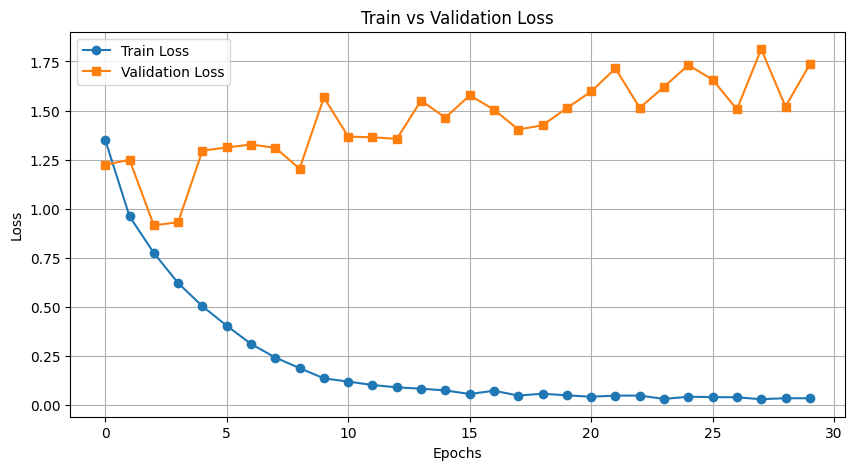

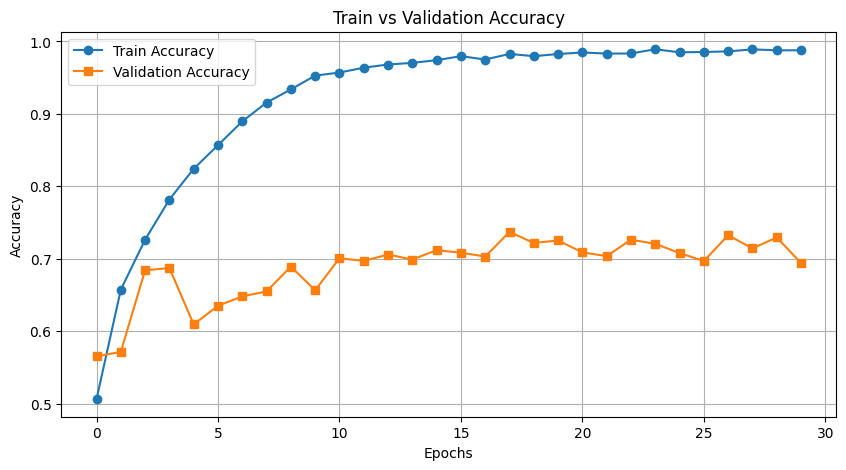

In [3]:
epochs = list(range(30))
train_loss = [1.3500, 0.9615, 0.7752, 0.6221, 0.5041, 0.4050, 0.3123, 0.2431, 0.1893, 0.1369,
              0.1208, 0.1033, 0.0914, 0.0845, 0.0755, 0.0575, 0.0740, 0.0495, 0.0589, 0.0507,
              0.0435, 0.0495, 0.0494, 0.0324, 0.0436, 0.0418, 0.0408, 0.0309, 0.0362, 0.0356]
train_acc = [0.5062, 0.6573, 0.7263, 0.7818, 0.8242, 0.8568, 0.8896, 0.9156, 0.9337, 0.9528,
             0.9570, 0.9637, 0.9681, 0.9704, 0.9741, 0.9796, 0.9750, 0.9827, 0.9796, 0.9826,
             0.9847, 0.9832, 0.9833, 0.9892, 0.9849, 0.9854, 0.9862, 0.9890, 0.9877, 0.9877]
val_loss = [1.2242, 1.2493, 0.9158, 0.9319, 1.2961, 1.3121, 1.3271, 1.3105, 1.2043, 1.5668,
            1.3675, 1.3640, 1.3559, 1.5508, 1.4639, 1.5773, 1.5052, 1.4034, 1.4254, 1.5127,
            1.5972, 1.7144, 1.5138, 1.6209, 1.7315, 1.6572, 1.5065, 1.8122, 1.5201, 1.7355]
val_acc = [0.5652, 0.5716, 0.6841, 0.6873, 0.6094, 0.6352, 0.6481, 0.6550, 0.6893, 0.6565,
           0.7008, 0.6970, 0.7059, 0.6990, 0.7119, 0.7084, 0.7031, 0.7371, 0.7218, 0.7253,
           0.7088, 0.7037, 0.7264, 0.7206, 0.7079, 0.6969, 0.7325, 0.7143, 0.7295, 0.6941]
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Pretrained Baseline

In [7]:
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)
pretrained_model = pretrained_model.to("cuda")
# pretrained_model = pretrained_model.to("mps")
wandb.init(project="custom-resnet-36-pretrained", entity="aryan-g")
pretrained_model = train_model(pretrained_model, train_loader, test_loader, num_epochs=30)
torch.save(model.state_dict(), "custom-resnet-36-pretrained.pth")
print("custom-resnet-36-pretrained saved successfully.")

/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0: train loss 0.7723, train acc 0.7355, val loss 0.6720, val acc 0.7644
Epoch 1: train loss 0.4330, train acc 0.8509, val loss 0.6193, val acc 0.7941
Epoch 2: train loss 0.3009, train acc 0.8964, val loss 0.6362, val acc 0.8032
Epoch 3: train loss 0.2172, train acc 0.9256, val loss 0.6707, val acc 0.7999
Epoch 4: train loss 0.1641, train acc 0.9431, val loss 0.7384, val acc 0.7940
Epoch 5: train loss 0.1351, train acc 0.9535, val loss 0.7305, val acc 0.8047
Epoch 6: train loss 0.1042, train acc 0.9646, val loss 0.9083, val acc 0.7763
Epoch 7: train loss 0.0783, train acc 0.9729, val loss 0.7339, val acc 0.8251
Epoch 8: train loss 0.0773, train acc 0.9737, val loss 0.8338, val acc 0.8125
Epoch 9: train loss 0.0637, train acc 0.9782, val loss 0.8646, val acc 0.7988
Epoch 10: train loss 0.0540, train acc 0.9817, val loss 0.8512, val acc 0.8055
Epoch 11: train loss 0.0497, train acc 0.9832, val loss 0.8504, val acc 0.8163
Epoch 12: train loss 0.0487, train acc 0.9835, val loss 1.0047

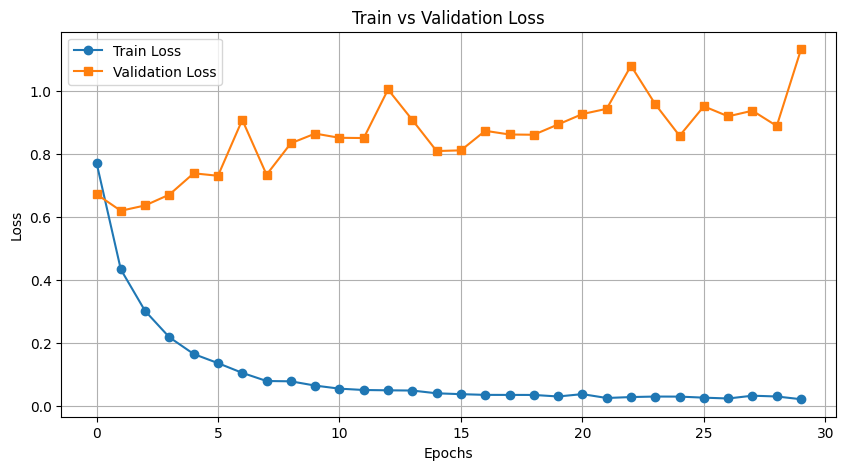

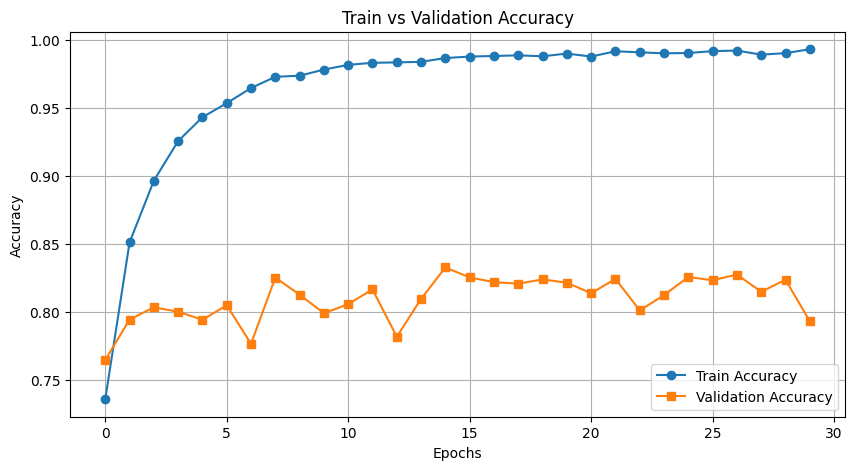

In [ ]:
epochs = list(range(30))
train_loss = [0.7723, 0.4330, 0.3009, 0.2172, 0.1641, 0.1351, 0.1042, 0.0783, 0.0773, 0.0637,
              0.0540, 0.0497, 0.0487, 0.0480, 0.0392, 0.0365, 0.0342, 0.0341, 0.0340, 0.0291,
              0.0366, 0.0243, 0.0273, 0.0289, 0.0287, 0.0254, 0.0227, 0.0316, 0.0291, 0.0204]
train_acc = [0.7355, 0.8509, 0.8964, 0.9256, 0.9431, 0.9535, 0.9646, 0.9729, 0.9737, 0.9782,
             0.9817, 0.9832, 0.9835, 0.9839, 0.9867, 0.9878, 0.9882, 0.9887, 0.9880, 0.9900,
             0.9878, 0.9917, 0.9909, 0.9902, 0.9904, 0.9918, 0.9922, 0.9892, 0.9903, 0.9932]
val_loss = [0.6720, 0.6193, 0.6362, 0.6707, 0.7384, 0.7305, 0.9083, 0.7339, 0.8338, 0.8646,
            0.8512, 0.8504, 1.0047, 0.9079, 0.8091, 0.8113, 0.8734, 0.8617, 0.8609, 0.8937,
            0.9267, 0.9433, 1.0802, 0.9579, 0.8575, 0.9513, 0.9194, 0.9373, 0.8888, 1.1327]
val_acc = [0.7644, 0.7941, 0.8032, 0.7999, 0.7940, 0.8047, 0.7763, 0.8251, 0.8125, 0.7988,
           0.8055, 0.8163, 0.7815, 0.8094, 0.8325, 0.8252, 0.8217, 0.8206, 0.8237, 0.8213,
           0.8135, 0.8241, 0.8009, 0.8121, 0.8255, 0.8231, 0.8273, 0.8146, 0.8235, 0.7929]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [27]:
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
print(pretrained_model)
print(f"Number of parameters: {sum(p.numel() for p in pretrained_model.parameters())}")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
def register_hooks(model):
    hooks = []
    def get_hook(name):
        def hook(module, input, output):
            print(f"{name} output shape: {output.shape}")
        return hook
    layers = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4']
    named_modules = dict(model.named_modules())
    for layer_name in layers:
        if layer_name in named_modules:
            hooks.append(named_modules[layer_name].register_forward_hook(get_hook(layer_name)))
    return hooks

dummy_input = torch.randn(1, 3, 224, 224).to(next(model.parameters()).device)
print("\n=== Intermediate feature map sizes for Custom ResNet18 ===")
hooks_custom = register_hooks(model)
_ = model(dummy_input)
for h in hooks_custom:
    h.remove()
print("\n=== Intermediate feature map sizes for Pretrained ResNet18 ===")
hooks_pretrained = register_hooks(pretrained_model)
_ = pretrained_model(dummy_input)
for h in hooks_pretrained:
    h.remove()


=== Intermediate feature map sizes for Custom ResNet18 ===
conv1 output shape: torch.Size([1, 64, 112, 112])
bn1 output shape: torch.Size([1, 64, 112, 112])
relu output shape: torch.Size([1, 64, 112, 112])
maxpool output shape: torch.Size([1, 64, 56, 56])
layer1 output shape: torch.Size([1, 64, 56, 56])
layer2 output shape: torch.Size([1, 128, 28, 28])
layer3 output shape: torch.Size([1, 256, 14, 14])
layer4 output shape: torch.Size([1, 512, 7, 7])

=== Intermediate feature map sizes for Pretrained ResNet18 ===
conv1 output shape: torch.Size([1, 64, 112, 112])
bn1 output shape: torch.Size([1, 64, 112, 112])
relu output shape: torch.Size([1, 64, 112, 112])
maxpool output shape: torch.Size([1, 64, 56, 56])
layer1 output shape: torch.Size([1, 64, 56, 56])
layer2 output shape: torch.Size([1, 128, 28, 28])
layer3 output shape: torch.Size([1, 256, 14, 14])
layer4 output shape: torch.Size([1, 512, 7, 7])


# Resized

In [17]:
class CustomDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor, transform=None):
        self.data = data_tensor
        self.labels = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        img = self.data[idx]
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy().astype(np.uint8)
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

torch.cuda.empty_cache()  
batch_size = 350
transform_resize = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
train_dataset_resized = CustomDataset(train_data, train_labels, transform=transform_resize)
test_dataset_resized = CustomDataset(test_data, test_labels, transform=transform_resize)
train_loader_resized = DataLoader(train_dataset_resized, batch_size=batch_size, shuffle=True)
test_loader_resized = DataLoader(test_dataset_resized, batch_size=batch_size)

In [ ]:
model_resized = models.resnet18(pretrained=False)
model_resized.fc = nn.Linear(model_resized.fc.in_features, num_classes)
# model_resized = model_resized.to("cuda")
model_resized = model_resized.to("mps")
# wandb.init(project="custom-resnet-224", entity="aryan-g")
model_resized = train_model(model_resized, train_loader_resized, test_loader_resized, num_epochs=0)
# torch.save(model_resized.state_dict(), "custom-resnet-224.pth")
# print("custom-resnet-224 saved successfully.")

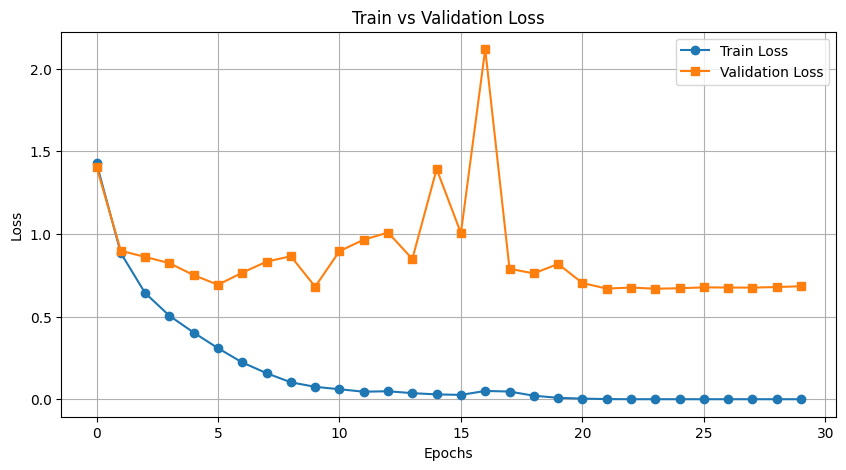

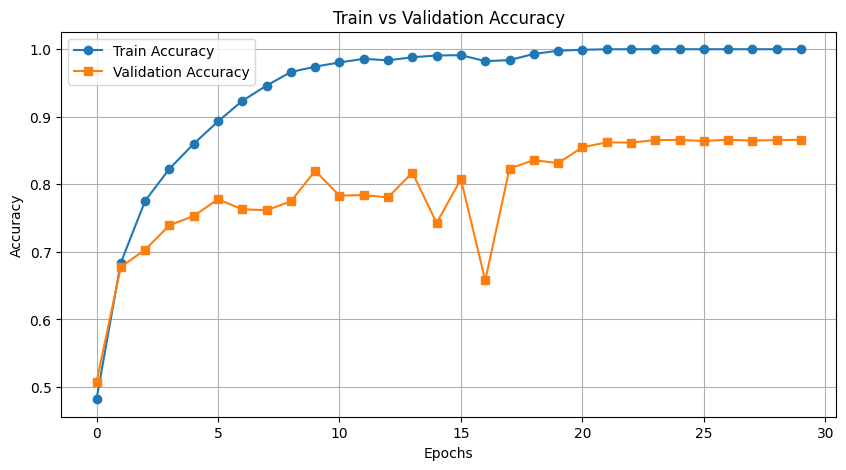

In [21]:
epochs = list(range(30))
train_loss = [1.4288, 0.8843, 0.6426, 0.5051, 0.4032, 0.3088, 0.2226, 0.1576, 0.1024, 0.0751,
              0.0604, 0.0456, 0.0484, 0.0367, 0.0293, 0.0263, 0.0502, 0.0465, 0.0214, 0.0086,
              0.0039, 0.0009, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
train_acc = [0.4820, 0.6839, 0.7755, 0.8230, 0.8600, 0.8931, 0.9235, 0.9462, 0.9662, 0.9742,
             0.9804, 0.9858, 0.9836, 0.9881, 0.9907, 0.9912, 0.9824, 0.9839, 0.9930, 0.9977,
             0.9992, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]
val_loss = [1.4064, 0.8982, 0.8609, 0.8232, 0.7507, 0.6925, 0.7654, 0.8322, 0.8650, 0.6807,
            0.8956, 0.9650, 1.0082, 0.8486, 1.3921, 1.0050, 2.1170, 0.7892, 0.7609, 0.8184,
            0.7030, 0.6692, 0.6755, 0.6685, 0.6712, 0.6766, 0.6756, 0.6751, 0.6787, 0.6834]
val_acc = [0.5073, 0.6778, 0.7032, 0.7394, 0.7532, 0.7780, 0.7630, 0.7618, 0.7748, 0.8201,
           0.7833, 0.7841, 0.7807, 0.8174, 0.7429, 0.8076, 0.6578, 0.8233, 0.8359, 0.8313,
           0.8549, 0.8621, 0.8618, 0.8655, 0.8658, 0.8642, 0.8660, 0.8649, 0.8654, 0.8660]


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [20]:
pretrained_model_resized = models.resnet18(pretrained=True)
pretrained_model_resized.fc = nn.Linear(pretrained_model_resized.fc.in_features, num_classes)
pretrained_model_resized = pretrained_model_resized.to("mps")
# pretrained_model_resized = pretrained_model_resized.to("cuda")
# wandb.init(project="custom-resnet-224-pretrained", entity="aryan-g")
pretrained_model_resized = train_model(pretrained_model_resized, train_loader_resized, test_loader_resized, num_epochs=0)
# torch.save(pretrained_model_resized.state_dict(), "custom-resnet-224-pretrained.pth")
# print("custom-resnet-224-pretrained saved successfully.")

/opt/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


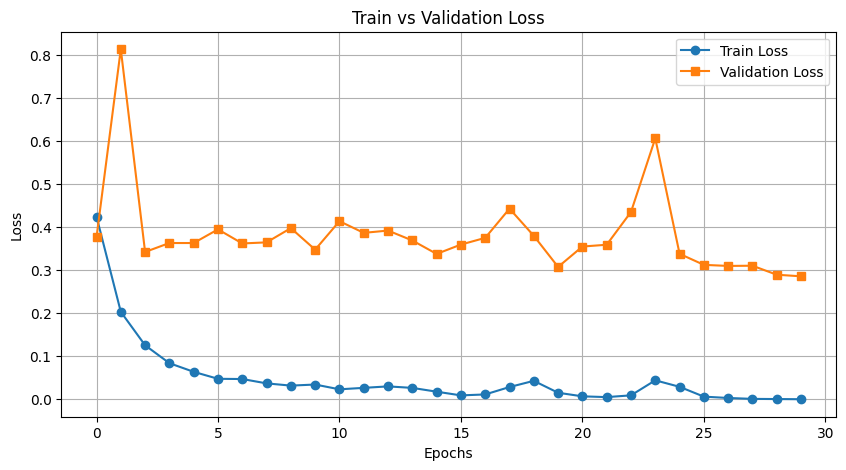

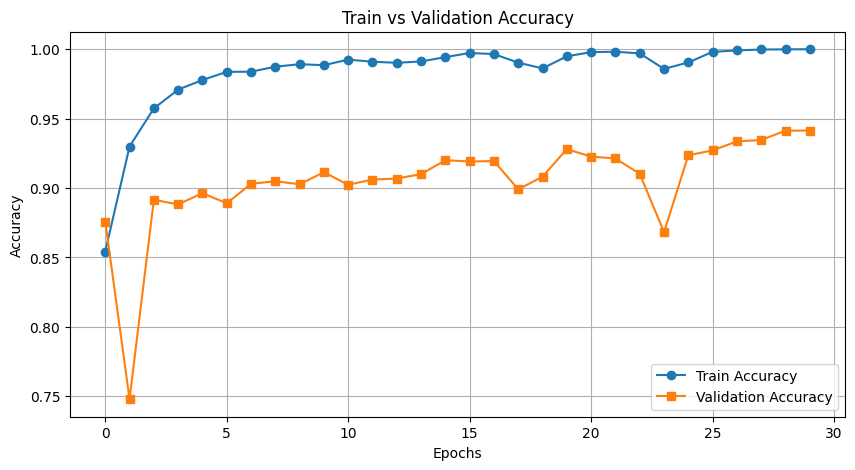

In [22]:
epochs = list(range(30))
train_loss = [0.4243, 0.2031, 0.1254, 0.0838, 0.0637, 0.0475, 0.0470, 0.0369, 0.0317, 0.0342,
              0.0231, 0.0265, 0.0299, 0.0264, 0.0176, 0.0090, 0.0112, 0.0284, 0.0428, 0.0151,
              0.0068, 0.0050, 0.0091, 0.0440, 0.0289, 0.0061, 0.0030, 0.0009, 0.0005, 0.0001]
train_acc = [0.8542, 0.9299, 0.9573, 0.9709, 0.9778, 0.9837, 0.9838, 0.9874, 0.9892, 0.9885,
             0.9925, 0.9910, 0.9902, 0.9912, 0.9943, 0.9973, 0.9965, 0.9903, 0.9862, 0.9949,
             0.9979, 0.9982, 0.9970, 0.9858, 0.9905, 0.9981, 0.9991, 0.9998, 0.9999, 1.0000]
val_loss = [0.3759, 0.8128, 0.3420, 0.3628, 0.3628, 0.3945, 0.3618, 0.3643, 0.3974, 0.3474,
            0.4135, 0.3864, 0.3917, 0.3687, 0.3375, 0.3592, 0.3748, 0.4426, 0.3795, 0.3073,
            0.3546, 0.3588, 0.4349, 0.6059, 0.3377, 0.3121, 0.3096, 0.3101, 0.2892, 0.2855]
val_acc = [0.8758, 0.7478, 0.8915, 0.8882, 0.8963, 0.8890, 0.9030, 0.9049, 0.9027, 0.9114,
           0.9023, 0.9061, 0.9068, 0.9100, 0.9200, 0.9191, 0.9194, 0.8990, 0.9082, 0.9280,
           0.9226, 0.9213, 0.9102, 0.8682, 0.9236, 0.9271, 0.9336, 0.9346, 0.9413, 0.9414]


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Comparison Report: ResNet18 on 36×36 vs 224×224 Images

- **From-Scratch ResNet18**
- **Pretrained ResNet18 (ImageNet initialization)**

Experiments were conducted using two different input resolutions:

1. **36×36 images** (original dataset size)
2. **224×224 images** (standard resolution)

Each model was trained for 30 epochs, and the following metrics were recorded:
- **Training Loss & Accuracy**
- **Validation Loss & Accuracy**

In addition, the change in compute requirements between the two resolutions is discussed.

---

## 1. Experimental Setup

- **Dataset:** Custom dataset originally sized at 36×36.
- **Preprocessing:** For the second set of experiments, the images were resized to 224×224.
- **Models:**
  - **ResNet18 from scratch:** Initialized with random weights.
  - **ResNet18 pretrained on ImageNet:** Initialized with weights from ImageNet training.
- **Training Details:** All models were trained for 30 epochs with similar hyperparameters.
- **Compute Impact:** Training on 36×36 images took approximately **10 minutes** per run, whereas the 224×224 experiments required about **2 hours** and significantly more VRAM.

---

## 2. Results

### 2.1. 36×36 Image Experiments

| Model                     | Final Training Loss | Final Training Accuracy | Final Validation Loss | Final Validation Accuracy |
|---------------------------|---------------------|-------------------------|-----------------------|---------------------------|
| **From Scratch** (Model A)  | 0.0356              | ~98.8%                  | 1.7355                | ~69.4%                    |
| **Pretrained** (Model B)    | 0.0204              | ~99.3%                  | 1.1327                | ~79.3%                    |

- **Observations:**
  - Both models achieved near-perfect training accuracy.
  - The pretrained model showed a significant improvement in generalization (≈79% vs. ≈69% validation accuracy).

---

### 2.2. 224×224 Image Experiments

| Model                     | Final Training Loss | Final Training Accuracy | Final Validation Loss | Final Validation Accuracy |
|---------------------------|---------------------|-------------------------|-----------------------|---------------------------|
| **From Scratch** (Model A)  | 0.0001              | 100%                    | 0.6834                | ~86.6%                    |
| **Pretrained** (Model B)    | 0.0001              | 100%                    | 0.2855                | ~94.1%                    |

- **Observations:**
  - Training accuracy reached 100% for both models.
  - Validation performance improved considerably compared to the 36×36 setup.
  - The pretrained model achieved almost 94% validation accuracy, outperforming the from-scratch model by roughly 7.5 percentage points.
  - Both training and validation losses decreased markedly with the higher resolution.

---

## 3. Discussion

1. **Improved Accuracy with 224×224 Images:**
   - **Detail and Information:** The higher resolution images provide more detail and richer features, which likely helped the models learn more discriminative patterns.
   - **Generalization:** Both models benefited, but the pretrained model showed a more pronounced improvement in validation accuracy.

2. **Computational Cost:**
   - **Training Time:** While experiments on 36×36 images completed in about **10 minutes**, the 224×224 experiments took approximately **2 hours**.
   - **Memory Requirements:** The increased input size led to significantly higher VRAM usage, as the model had to process larger tensors and more intermediate feature maps.
   - **Trade-off:** The enhanced accuracy with 224×224 images comes at the cost of increased computational resources and time.

3. **Overfitting Considerations:**
   - For the 36×36 experiments, the gap between training and validation accuracy (especially in the from-scratch model) suggested overfitting.
   - With 224×224 images, although training accuracy reached 100%, the pretrained model maintained better validation performance, indicating improved generalization when using more detailed images and leveraging pretrained features.

---

## 4. Conclusion

Resizing the custom dataset images from 36×36 to 224×224 resulted in:
- **Higher accuracy:** Both models, especially the pretrained ResNet18, showed substantial improvements in validation accuracy (from ~69–79% to ~87–94%).
- **Lower losses:** Both training and validation losses decreased with the higher resolution.
- **Increased computational demand:** The standard 224×224 resolution required significantly more training time (2 hours vs. 10 minutes) and VRAM.

**Takeaway:**  
While using standard 224×224 images improves model performance due to richer input details, it also demands more compute resources. This trade-off should be considered when designing and deploying deep learning systems, particularly in resource-constrained environments.

---


# Modifications

## 1

In [ ]:
def modify_initial_layers(model, kernel_size=3, stride=1, remove_maxpool=True):
    in_channels = model.conv1.in_channels
    out_channels = model.conv1.out_channels
    model.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
    if remove_maxpool:
        model.maxpool = nn.Identity()
    return model

model_mod1 = models.resnet18(pretrained=False)
model_mod1.fc = nn.Linear(model_mod1.fc.in_features, num_classes)
model_mod1 = modify_initial_layers(model_mod1, kernel_size=3, stride=1, remove_maxpool=True)
# model_mod1 = model_mod1.to("mps")
model_mod1 = model_mod1.to("cuda")
wandb.init(project="custom-resnet-36-mod1", entity="aryan-g")
model_mod1 = train_model(model_mod1, train_loader, test_loader, num_epochs=30)
torch.save(model_mod1.state_dict(), "custom-resnet-36-mod1.pth")
print("custom-resnet-36-mod1 saved successfully.")

/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0: train loss 1.4014, train acc 0.4870, val loss 1.2227, val acc 0.5552
Epoch 1: train loss 0.8796, train acc 0.6875, val loss 0.9914, val acc 0.6627
Epoch 2: train loss 0.6508, train acc 0.7719, val loss 0.9244, val acc 0.6935
Epoch 3: train loss 0.4916, train acc 0.8295, val loss 0.7415, val acc 0.7553
Epoch 4: train loss 0.3816, train acc 0.8665, val loss 0.9248, val acc 0.7325
Epoch 5: train loss 0.2874, train acc 0.9002, val loss 0.7434, val acc 0.7658
Epoch 6: train loss 0.1978, train acc 0.9313, val loss 0.9128, val acc 0.7464
Epoch 7: train loss 0.1351, train acc 0.9536, val loss 0.7521, val acc 0.7963
Epoch 8: train loss 0.0919, train acc 0.9687, val loss 1.2614, val acc 0.7316
Epoch 9: train loss 0.0749, train acc 0.9741, val loss 0.8281, val acc 0.7966
Epoch 10: train loss 0.0608, train acc 0.9793, val loss 0.9373, val acc 0.7864
Epoch 11: train loss 0.0530, train acc 0.9816, val loss 0.8375, val acc 0.8082
Epoch 12: train loss 0.0430, train acc 0.9856, val loss 1.1044

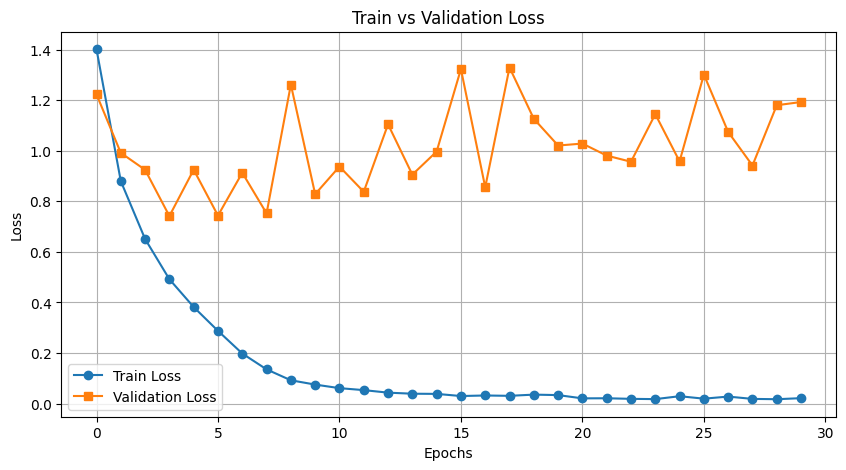

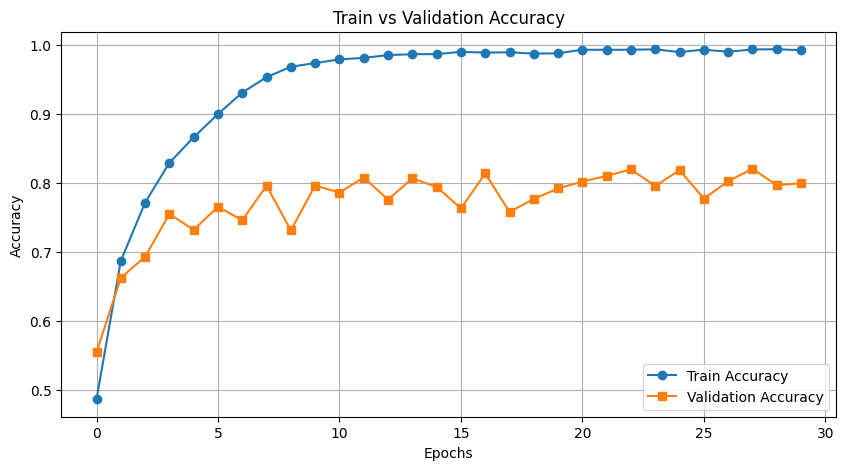

In [5]:
epochs = list(range(30))
train_loss = [1.4014, 0.8796, 0.6508, 0.4916, 0.3816, 0.2874, 0.1978, 0.1351, 0.0919, 0.0749,
              0.0608, 0.0530, 0.0430, 0.0388, 0.0381, 0.0296, 0.0318, 0.0304, 0.0352, 0.0333,
              0.0204, 0.0208, 0.0185, 0.0174, 0.0289, 0.0192, 0.0274, 0.0183, 0.0170, 0.0212]
train_acc = [0.4870, 0.6875, 0.7719, 0.8295, 0.8665, 0.9002, 0.9313, 0.9536, 0.9687, 0.9741,
             0.9793, 0.9816, 0.9856, 0.9869, 0.9870, 0.9903, 0.9892, 0.9897, 0.9877, 0.9882,
             0.9934, 0.9932, 0.9934, 0.9939, 0.9900, 0.9935, 0.9904, 0.9937, 0.9941, 0.9927]
val_loss = [1.2227, 0.9914, 0.9244, 0.7415, 0.9248, 0.7434, 0.9128, 0.7521, 1.2614, 0.8281,
            0.9373, 0.8375, 1.1044, 0.9053, 0.9967, 1.3229, 0.8553, 1.3291, 1.1262, 1.0205,
            1.0282, 0.9807, 0.9563, 1.1446, 0.9577, 1.3012, 1.0742, 0.9414, 1.1798, 1.1926]
val_acc = [0.5552, 0.6627, 0.6935, 0.7553, 0.7325, 0.7658, 0.7464, 0.7963, 0.7316, 0.7966,
           0.7864, 0.8082, 0.7763, 0.8069, 0.7947, 0.7635, 0.8141, 0.7584, 0.7771, 0.7924,
           0.8024, 0.8106, 0.8199, 0.7959, 0.8189, 0.7776, 0.8028, 0.8209, 0.7971, 0.7999]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def modify_pretrained_model(model, kernel_size=3, stride=1, remove_maxpool=True):
    in_channels = model.conv1.in_channels
    out_channels = model.conv1.out_channels
    new_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
    nn.init.kaiming_normal_(new_conv1.weight, mode='fan_out', nonlinearity='relu')
    model.conv1 = new_conv1
    if remove_maxpool:
        model.maxpool = nn.Identity()
    return model

pretrained_mod1 = models.resnet18(pretrained=True)
pretrained_mod1.fc = nn.Linear(pretrained_mod1.fc.in_features, num_classes)
pretrained_mod1 = modify_pretrained_model(pretrained_mod1, kernel_size=3, stride=1, remove_maxpool=True)
# pretrained_mod1 = pretrained_mod1.to("mps")
pretrained_mod1 = pretrained_mod1.to("cuda")
wandb.init(project="custom-resnet-36-pretrained-mod1", entity="aryan-g")
pretrained_mod1 = train_model(pretrained_mod1, train_loader, test_loader, num_epochs=30)
torch.save(pretrained_mod1.state_dict(), "custom-resnet-36-mod1-pretrained.pth")
print("custom-resnet-36-mod1-pretrained saved successfully.")

/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0: train loss 0.6640, train acc 0.7690, val loss 0.5433, val acc 0.8209
Epoch 1: train loss 0.2785, train acc 0.9035, val loss 0.4144, val acc 0.8569
Epoch 2: train loss 0.1586, train acc 0.9446, val loss 0.4319, val acc 0.8686
Epoch 3: train loss 0.1020, train acc 0.9648, val loss 0.3709, val acc 0.8873
Epoch 4: train loss 0.0693, train acc 0.9765, val loss 0.4610, val acc 0.8753
Epoch 5: train loss 0.0554, train acc 0.9809, val loss 0.4909, val acc 0.8788
Epoch 6: train loss 0.0465, train acc 0.9842, val loss 0.5168, val acc 0.8698
Epoch 7: train loss 0.0364, train acc 0.9871, val loss 0.4757, val acc 0.8839
Epoch 8: train loss 0.0299, train acc 0.9904, val loss 0.4134, val acc 0.8955
Epoch 9: train loss 0.0309, train acc 0.9890, val loss 0.5831, val acc 0.8687
Epoch 10: train loss 0.0385, train acc 0.9872, val loss 0.6321, val acc 0.8562
Epoch 11: train loss 0.0298, train acc 0.9899, val loss 0.4968, val acc 0.8873
Epoch 12: train loss 0.0211, train acc 0.9926, val loss 0.4102

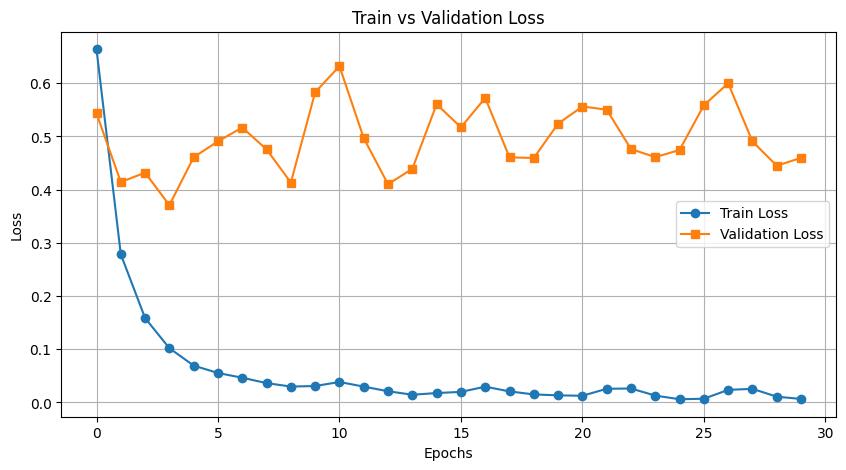

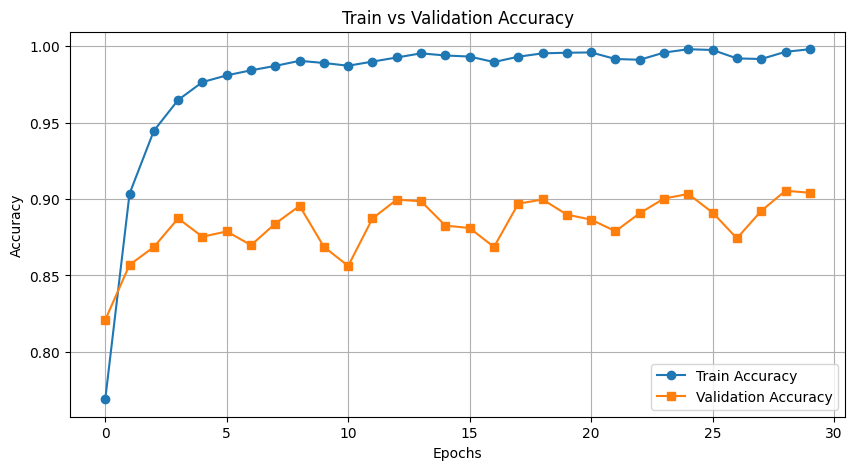

In [ ]:
epochs = list(range(30))
train_loss = [0.6640, 0.2785, 0.1586, 0.1020, 0.0693, 0.0554, 0.0465, 0.0364, 0.0299, 0.0309,
              0.0385, 0.0298, 0.0211, 0.0145, 0.0177, 0.0199, 0.0297, 0.0208, 0.0151, 0.0134,
              0.0126, 0.0257, 0.0263, 0.0129, 0.0061, 0.0070, 0.0237, 0.0256, 0.0109, 0.0066]
train_acc = [0.7690, 0.9035, 0.9446, 0.9648, 0.9765, 0.9809, 0.9842, 0.9871, 0.9904, 0.9890,
             0.9872, 0.9899, 0.9926, 0.9953, 0.9939, 0.9932, 0.9896, 0.9931, 0.9953, 0.9957,
             0.9959, 0.9916, 0.9911, 0.9958, 0.9980, 0.9975, 0.9920, 0.9916, 0.9963, 0.9980]
val_loss = [0.5433, 0.4144, 0.4319, 0.3709, 0.4610, 0.4909, 0.5168, 0.4757, 0.4134, 0.5831,
            0.6321, 0.4968, 0.4102, 0.4392, 0.5606, 0.5172, 0.5724, 0.4607, 0.4596, 0.5241,
            0.5563, 0.5504, 0.4764, 0.4611, 0.4746, 0.5587, 0.6000, 0.4906, 0.4450, 0.4598]
val_acc = [0.8209, 0.8569, 0.8686, 0.8873, 0.8753, 0.8788, 0.8698, 0.8839, 0.8955, 0.8687,
           0.8562, 0.8873, 0.8996, 0.8985, 0.8826, 0.8810, 0.8686, 0.8969, 0.8997, 0.8898,
           0.8865, 0.8789, 0.8907, 0.9003, 0.9033, 0.8911, 0.8743, 0.8922, 0.9054, 0.9041]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

## 2

In [ ]:
def modify_model_mod2(model, kernel_size=5, stride=1, remove_maxpool=False):
    in_channels = model.conv1.in_channels
    out_channels = model.conv1.out_channels
    new_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
    nn.init.kaiming_normal_(new_conv1.weight, mode='fan_out', nonlinearity='relu')
    model.conv1 = new_conv1
    return model

model_mod2 = models.resnet18(pretrained=False)
model_mod2.fc = nn.Linear(model_mod2.fc.in_features, num_classes)
model_mod2 = modify_model_mod2(model_mod2, kernel_size=5, stride=1, remove_maxpool=False)
# model_mod2 = model_mod2.to("mps")
model_mod2 = model_mod2.to("cuda")
wandb.init(project="custom-resnet-36-mod2", entity="aryan-g")
model_mod2 = train_model(model_mod2, train_loader, test_loader, num_epochs=30)
torch.save(model_mod2.state_dict(), "custom-resnet-36-mod2.pth")
print("custom-resnet-36-mod2 saved successfully.")

/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0: train loss 1.3270, train acc 0.5184, val loss 1.3586, val acc 0.5445
Epoch 1: train loss 0.8629, train acc 0.6935, val loss 0.9565, val acc 0.6581
Epoch 2: train loss 0.6572, train acc 0.7674, val loss 1.1602, val acc 0.6279
Epoch 3: train loss 0.5002, train acc 0.8243, val loss 1.0064, val acc 0.6737
Epoch 4: train loss 0.3815, train acc 0.8657, val loss 1.0423, val acc 0.6731
Epoch 5: train loss 0.2766, train acc 0.9038, val loss 1.1393, val acc 0.6963
Epoch 6: train loss 0.2034, train acc 0.9291, val loss 0.9251, val acc 0.7465
Epoch 7: train loss 0.1463, train acc 0.9475, val loss 1.1230, val acc 0.7373
Epoch 8: train loss 0.1190, train acc 0.9573, val loss 1.0053, val acc 0.7535
Epoch 9: train loss 0.0752, train acc 0.9736, val loss 1.1820, val acc 0.7410
Epoch 10: train loss 0.0651, train acc 0.9775, val loss 1.1287, val acc 0.7566
Epoch 11: train loss 0.0682, train acc 0.9760, val loss 1.1081, val acc 0.7612
Epoch 12: train loss 0.0683, train acc 0.9760, val loss 1.2563

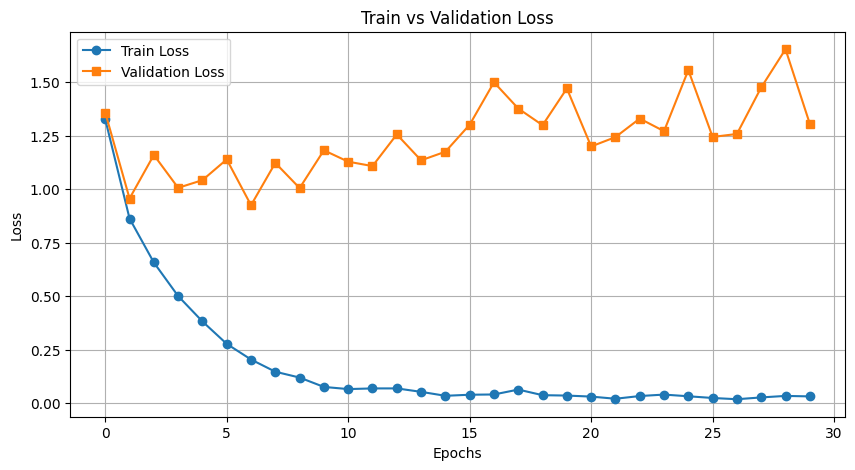

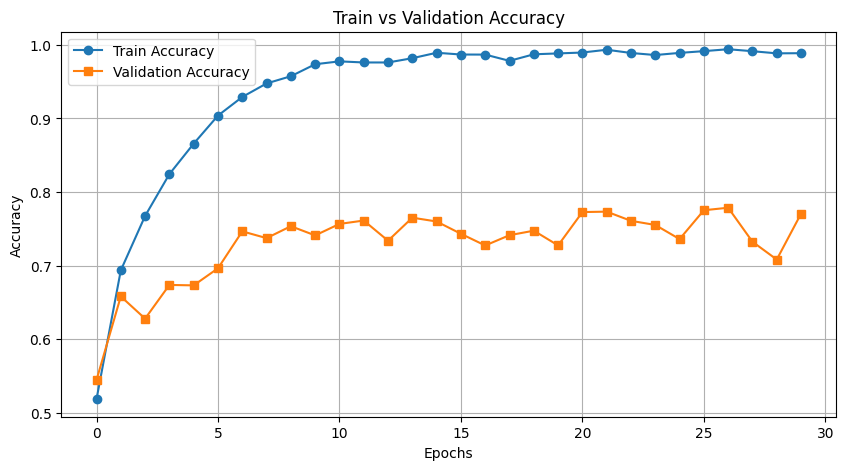

In [7]:
epochs = list(range(30))
train_loss = [1.3270, 0.8629, 0.6572, 0.5002, 0.3815, 0.2766, 0.2034, 0.1463, 0.1190, 0.0752,
              0.0651, 0.0682, 0.0683, 0.0522, 0.0337, 0.0387, 0.0399, 0.0628, 0.0366, 0.0348,
              0.0300, 0.0199, 0.0326, 0.0394, 0.0315, 0.0235, 0.0177, 0.0261, 0.0332, 0.0309]
train_acc = [0.5184, 0.6935, 0.7674, 0.8243, 0.8657, 0.9038, 0.9291, 0.9475, 0.9573, 0.9736,
             0.9775, 0.9760, 0.9760, 0.9818, 0.9892, 0.9868, 0.9867, 0.9782, 0.9871, 0.9883,
             0.9895, 0.9933, 0.9889, 0.9861, 0.9890, 0.9914, 0.9940, 0.9913, 0.9884, 0.9886]
val_loss = [1.3586, 0.9565, 1.1602, 1.0064, 1.0423, 1.1393, 0.9251, 1.1230, 1.0053, 1.1820,
            1.1287, 1.1081, 1.2563, 1.1351, 1.1753, 1.3017, 1.5001, 1.3773, 1.2994, 1.4711,
            1.1999, 1.2436, 1.3303, 1.2713, 1.5569, 1.2444, 1.2583, 1.4760, 1.6547, 1.3060]
val_acc = [0.5445, 0.6581, 0.6279, 0.6737, 0.6731, 0.6963, 0.7465, 0.7373, 0.7535, 0.7410,
           0.7566, 0.7612, 0.7338, 0.7651, 0.7599, 0.7432, 0.7273, 0.7413, 0.7474, 0.7274,
           0.7727, 0.7733, 0.7608, 0.7552, 0.7360, 0.7752, 0.7786, 0.7324, 0.7082, 0.7705]


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def modify_pretrained_model_mod2(model, kernel_size=5, stride=1, remove_maxpool=False):
    in_channels = model.conv1.in_channels
    out_channels = model.conv1.out_channels
    new_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
    nn.init.kaiming_normal_(new_conv1.weight, mode='fan_out', nonlinearity='relu')
    model.conv1 = new_conv1
    return model

pretrained_mod2 = models.resnet18(pretrained=True)
pretrained_mod2.fc = nn.Linear(pretrained_mod2.fc.in_features, num_classes)
pretrained_mod2 = modify_pretrained_model_mod2(pretrained_mod2, kernel_size=5, stride=1, remove_maxpool=False)
# pretrained_mod2 = pretrained_mod2.to("mps")
pretrained_mod2 = pretrained_mod2.to("cuda")
wandb.init(project="custom-resnet-36-pretrained-mod2", entity="aryan-g")
pretrained_mod2 = train_model(pretrained_mod2, train_loader, test_loader, num_epochs=30)
torch.save(pretrained_mod2.state_dict(), "custom-resnet-36-pretrained-mod2.pth")
print("custom-resnet-36-pretrained-mod2 saved successfully.")

/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0: train loss 0.9986, train acc 0.6436, val loss 0.7735, val acc 0.7302
Epoch 1: train loss 0.5471, train acc 0.8101, val loss 0.6990, val acc 0.7677
Epoch 2: train loss 0.3608, train acc 0.8743, val loss 0.7718, val acc 0.7472
Epoch 3: train loss 0.2403, train acc 0.9171, val loss 0.7411, val acc 0.7828
Epoch 4: train loss 0.1711, train acc 0.9398, val loss 0.7288, val acc 0.7977
Epoch 5: train loss 0.1232, train acc 0.9572, val loss 0.8362, val acc 0.7821
Epoch 6: train loss 0.0858, train acc 0.9701, val loss 0.7901, val acc 0.7993
Epoch 7: train loss 0.0802, train acc 0.9721, val loss 0.8425, val acc 0.8090
Epoch 8: train loss 0.0615, train acc 0.9792, val loss 1.0933, val acc 0.7739
Epoch 9: train loss 0.0583, train acc 0.9799, val loss 0.9233, val acc 0.7954
Epoch 10: train loss 0.0444, train acc 0.9846, val loss 0.9489, val acc 0.7931
Epoch 11: train loss 0.0403, train acc 0.9862, val loss 0.9283, val acc 0.8058
Epoch 12: train loss 0.0339, train acc 0.9889, val loss 1.1669

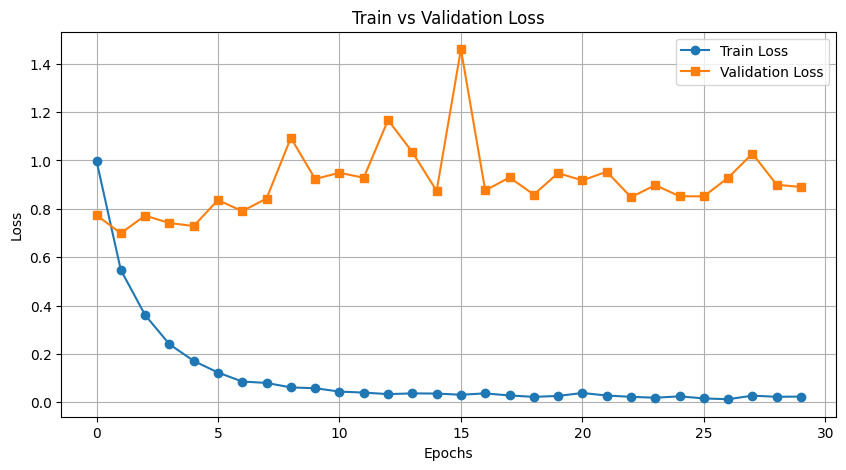

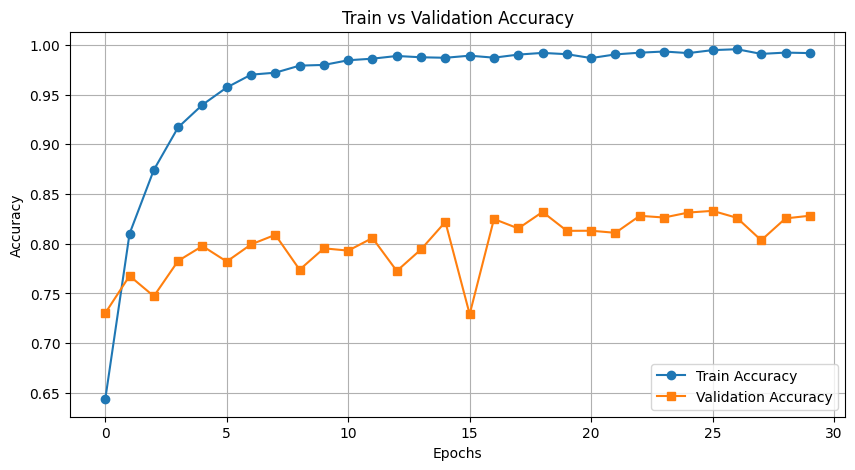

In [8]:
epochs = list(range(30))
train_loss = [0.9986, 0.5471, 0.3608, 0.2403, 0.1711, 0.1232, 0.0858, 0.0802, 0.0615, 0.0583,
              0.0444, 0.0403, 0.0339, 0.0369, 0.0362, 0.0313, 0.0370, 0.0282, 0.0226, 0.0264,
              0.0386, 0.0281, 0.0227, 0.0190, 0.0247, 0.0161, 0.0128, 0.0277, 0.0228, 0.0238]
train_acc = [0.6436, 0.8101, 0.8743, 0.9171, 0.9398, 0.9572, 0.9701, 0.9721, 0.9792, 0.9799,
             0.9846, 0.9862, 0.9889, 0.9876, 0.9871, 0.9892, 0.9872, 0.9903, 0.9920, 0.9907,
             0.9868, 0.9905, 0.9922, 0.9934, 0.9918, 0.9948, 0.9957, 0.9910, 0.9923, 0.9918]
val_loss = [0.7735, 0.6990, 0.7718, 0.7411, 0.7288, 0.8362, 0.7901, 0.8425, 1.0933, 0.9233,
            0.9489, 0.9283, 1.1669, 1.0344, 0.8740, 1.4596, 0.8758, 0.9296, 0.8587, 0.9475,
            0.9173, 0.9534, 0.8482, 0.8978, 0.8520, 0.8513, 0.9286, 1.0282, 0.8992, 0.8902]
val_acc = [0.7302, 0.7677, 0.7472, 0.7828, 0.7977, 0.7821, 0.7993, 0.8090, 0.7739, 0.7954,
           0.7931, 0.8058, 0.7726, 0.7944, 0.8220, 0.7291, 0.8249, 0.8154, 0.8320, 0.8130,
           0.8131, 0.8110, 0.8281, 0.8264, 0.8314, 0.8331, 0.8261, 0.8035, 0.8255, 0.8282]


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

## 3

In [ ]:
def modify_model_mod3(model, remove_maxpool=True):
    in_channels = model.conv1.in_channels
    mid_channels = model.conv1.out_channels   
    conv1a = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False)
    nn.init.kaiming_normal_(conv1a.weight, mode='fan_out', nonlinearity='relu')
    conv1b = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False)
    nn.init.kaiming_normal_(conv1b.weight, mode='fan_out', nonlinearity='relu')
    new_conv_block = nn.Sequential( conv1a, nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True), conv1b, nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True) )
    model.conv1 = new_conv_block
    if remove_maxpool:
        model.maxpool = nn.Identity()
    return model

model_mod3 = models.resnet18(pretrained=False)
model_mod3.fc = nn.Linear(model_mod3.fc.in_features, num_classes)
model_mod3 = modify_model_mod3(model_mod3, remove_maxpool=True)
# model_mod3 = model_mod3.to("mps")
model_mod3 = model_mod3.to("cuda")
wandb.init(project="custom-resnet-36-mod3", entity="aryan-g")
model_mod3 = train_model(model_mod3, train_loader, test_loader, num_epochs=30)
torch.save(model_mod3.state_dict(), "custom-resnet-36-mod3.pth")
print("custom-resnet-36-mod3 saved successfully.")

/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0: train loss 1.3917, train acc 0.4889, val loss 1.3387, val acc 0.5143
Epoch 1: train loss 0.8880, train acc 0.6832, val loss 1.4432, val acc 0.5563
Epoch 2: train loss 0.6561, train acc 0.7680, val loss 0.9780, val acc 0.6601
Epoch 3: train loss 0.5030, train acc 0.8243, val loss 0.9395, val acc 0.7144
Epoch 4: train loss 0.3837, train acc 0.8661, val loss 0.7869, val acc 0.7419
Epoch 5: train loss 0.2776, train acc 0.9023, val loss 0.8095, val acc 0.7604
Epoch 6: train loss 0.1958, train acc 0.9325, val loss 0.9437, val acc 0.7553
Epoch 7: train loss 0.1453, train acc 0.9506, val loss 0.9504, val acc 0.7571
Epoch 8: train loss 0.1025, train acc 0.9651, val loss 0.8441, val acc 0.7809
Epoch 9: train loss 0.0734, train acc 0.9749, val loss 0.7507, val acc 0.8080
Epoch 10: train loss 0.0530, train acc 0.9820, val loss 0.8505, val acc 0.8015
Epoch 11: train loss 0.0595, train acc 0.9797, val loss 0.9987, val acc 0.7807
Epoch 12: train loss 0.0475, train acc 0.9837, val loss 1.0513

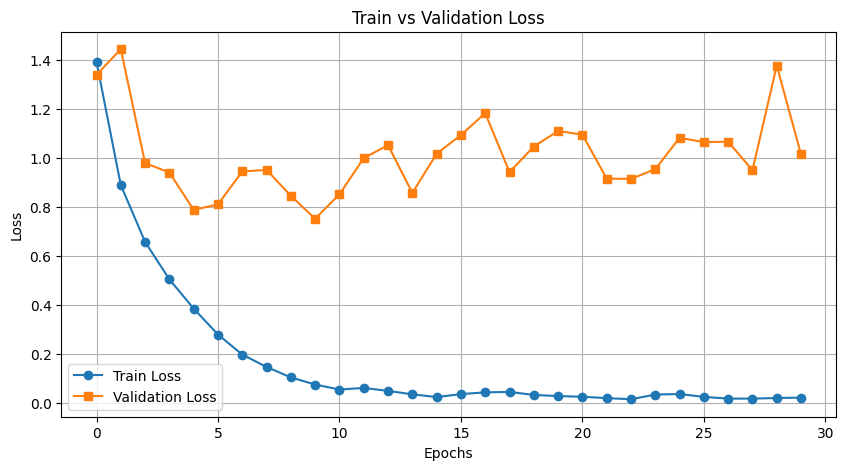

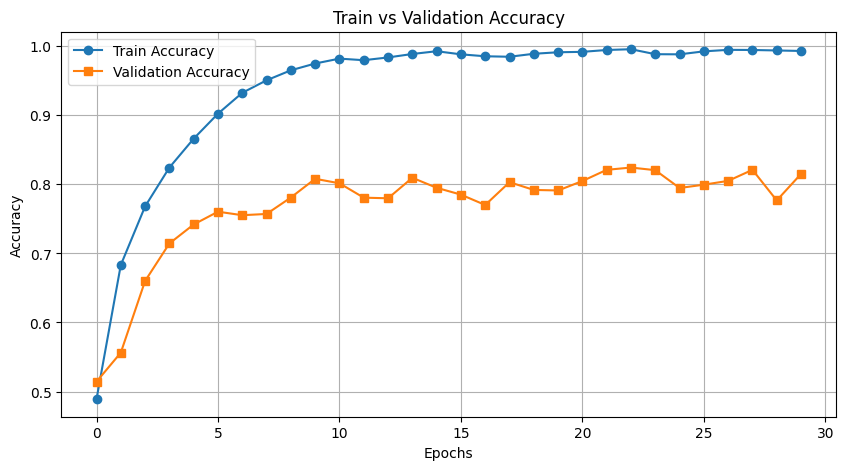

In [9]:
epochs = list(range(30))
train_loss = [1.3917, 0.8880, 0.6561, 0.5030, 0.3837, 0.2776, 0.1958, 0.1453, 0.1025, 0.0734,
              0.0530, 0.0595, 0.0475, 0.0334, 0.0223, 0.0343, 0.0415, 0.0431, 0.0310, 0.0263,
              0.0234, 0.0179, 0.0134, 0.0325, 0.0346, 0.0229, 0.0159, 0.0159, 0.0183, 0.0201]
train_acc = [0.4889, 0.6832, 0.7680, 0.8243, 0.8661, 0.9023, 0.9325, 0.9506, 0.9651, 0.9749,
             0.9820, 0.9797, 0.9837, 0.9887, 0.9927, 0.9882, 0.9854, 0.9847, 0.9890, 0.9912,
             0.9918, 0.9945, 0.9956, 0.9884, 0.9882, 0.9925, 0.9947, 0.9945, 0.9938, 0.9931]
val_loss = [1.3387, 1.4432, 0.9780, 0.9395, 0.7869, 0.8095, 0.9437, 0.9504, 0.8441, 0.7507,
            0.8505, 0.9987, 1.0513, 0.8562, 1.0164, 1.0924, 1.1819, 0.9415, 1.0455, 1.1093,
            1.0939, 0.9149, 0.9133, 0.9533, 1.0814, 1.0637, 1.0653, 0.9492, 1.3761, 1.0134]
val_acc = [0.5143, 0.5563, 0.6601, 0.7144, 0.7419, 0.7604, 0.7553, 0.7571, 0.7809, 0.8080,
           0.8015, 0.7807, 0.7798, 0.8095, 0.7950, 0.7851, 0.7701, 0.8031, 0.7919, 0.7911,
           0.8048, 0.8210, 0.8243, 0.8205, 0.7947, 0.7995, 0.8050, 0.8210, 0.7767, 0.8151]


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def modify_pretrained_model_mod3(model, remove_maxpool=True):
    in_channels = model.conv1.in_channels
    mid_channels = model.conv1.out_channels  
    conv1a = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False)
    nn.init.kaiming_normal_(conv1a.weight, mode='fan_out', nonlinearity='relu')
    conv1b = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False)
    nn.init.kaiming_normal_(conv1b.weight, mode='fan_out', nonlinearity='relu')
    new_conv_block = nn.Sequential( conv1a, nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True), conv1b, nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True) )
    model.conv1 = new_conv_block
    if remove_maxpool:
        model.maxpool = nn.Identity()
    return model

pretrained_mod3 = models.resnet18(pretrained=True)
pretrained_mod3.fc = nn.Linear(pretrained_mod3.fc.in_features, num_classes)
pretrained_mod3 = modify_pretrained_model_mod3(pretrained_mod3, remove_maxpool=True)
# pretrained_mod3 = pretrained_mod3.to("mps")
pretrained_mod3 = pretrained_mod3.to("cuda")
wandb.init(project="custom-resnet-36-pretrained-mod3", entity="aryan-g")
pretrained_mod3 = train_model(pretrained_mod3, train_loader, test_loader, num_epochs=30)
torch.save(pretrained_mod3.state_dict(), "custom-resnet-36-pretrained-mod3.pth")
print("custom-resnet-36-pretrained-mod3 saved successfully.")

/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0: train loss 0.7790, train acc 0.7251, val loss 0.6727, val acc 0.7696
Epoch 1: train loss 0.3614, train acc 0.8746, val loss 0.8338, val acc 0.7367
Epoch 2: train loss 0.2130, train acc 0.9270, val loss 0.4749, val acc 0.8457
Epoch 3: train loss 0.1290, train acc 0.9554, val loss 0.4834, val acc 0.8611
Epoch 4: train loss 0.0925, train acc 0.9684, val loss 0.6371, val acc 0.8242
Epoch 5: train loss 0.0739, train acc 0.9748, val loss 0.4852, val acc 0.8720
Epoch 6: train loss 0.0498, train acc 0.9830, val loss 0.5593, val acc 0.8618
Epoch 7: train loss 0.0383, train acc 0.9873, val loss 0.5576, val acc 0.8678
Epoch 8: train loss 0.0446, train acc 0.9851, val loss 0.5094, val acc 0.8721
Epoch 9: train loss 0.0407, train acc 0.9865, val loss 0.7805, val acc 0.8309
Epoch 10: train loss 0.0284, train acc 0.9906, val loss 0.4773, val acc 0.8859
Epoch 11: train loss 0.0252, train acc 0.9914, val loss 0.5413, val acc 0.8795
Epoch 12: train loss 0.0295, train acc 0.9896, val loss 0.5442

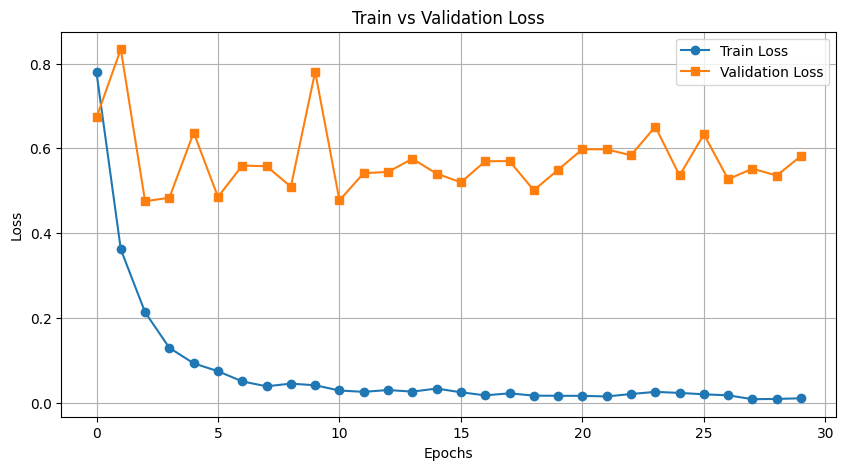

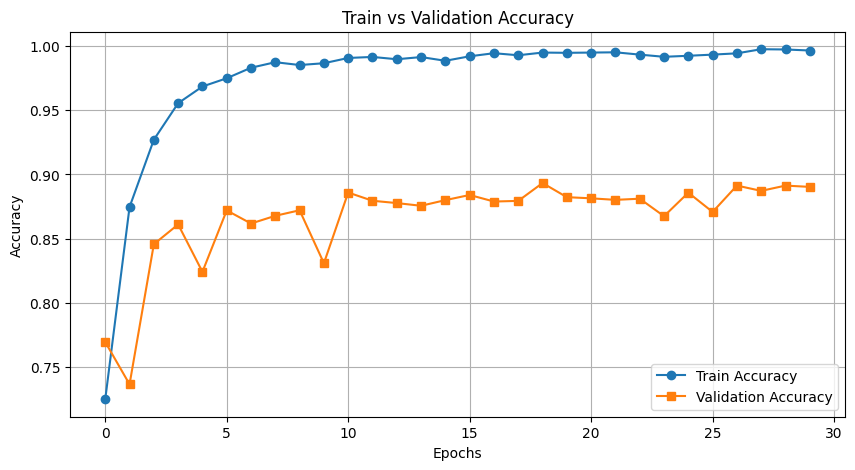

In [10]:
epochs = list(range(30))
train_loss = [0.7790, 0.3614, 0.2130, 0.1290, 0.0925, 0.0739, 0.0498, 0.0383, 0.0446, 0.0407,
              0.0284, 0.0252, 0.0295, 0.0257, 0.0330, 0.0242, 0.0169, 0.0217, 0.0163, 0.0159,
              0.0158, 0.0143, 0.0201, 0.0251, 0.0227, 0.0194, 0.0170, 0.0078, 0.0085, 0.0100]
train_acc = [0.7251, 0.8746, 0.9270, 0.9554, 0.9684, 0.9748, 0.9830, 0.9873, 0.9851, 0.9865,
             0.9906, 0.9914, 0.9896, 0.9913, 0.9884, 0.9919, 0.9943, 0.9927, 0.9948, 0.9946,
             0.9948, 0.9950, 0.9932, 0.9915, 0.9923, 0.9932, 0.9942, 0.9974, 0.9972, 0.9964]
val_loss = [0.6727, 0.8338, 0.4749, 0.4834, 0.6371, 0.4852, 0.5593, 0.5576, 0.5094, 0.7805,
            0.4773, 0.5413, 0.5442, 0.5752, 0.5402, 0.5197, 0.5694, 0.5698, 0.5009, 0.5493,
            0.5977, 0.5976, 0.5834, 0.6511, 0.5359, 0.6328, 0.5271, 0.5519, 0.5357, 0.5820]
val_acc = [0.7696, 0.7367, 0.8457, 0.8611, 0.8242, 0.8720, 0.8618, 0.8678, 0.8721, 0.8309,
           0.8859, 0.8795, 0.8777, 0.8756, 0.8800, 0.8840, 0.8789, 0.8794, 0.8933, 0.8823,
           0.8814, 0.8802, 0.8811, 0.8675, 0.8858, 0.8708, 0.8913, 0.8872, 0.8913, 0.8903]


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

## 4

In [ ]:
def modify_model_mod4(model):
    in_channels = model.conv1.in_channels
    out_channels = model.conv1.out_channels
    new_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    nn.init.kaiming_normal_(new_conv1.weight, mode='fan_out', nonlinearity='relu')
    model.conv1 = new_conv1
    downsample = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
    nn.init.kaiming_normal_(downsample.weight, mode='fan_out', nonlinearity='relu')
    model.maxpool = downsample
    return model

model_mod4 = models.resnet18(pretrained=False)
model_mod4.fc = nn.Linear(model_mod4.fc.in_features, num_classes)
model_mod4 = modify_model_mod4(model_mod4)
# model_mod4 = model_mod4.to("mps")
model_mod4 = model_mod4.to("cuda")
wandb.init(project="custom-resnet-36-mod4", entity="aryan-g")
model_mod4 = train_model(model_mod4, train_loader, test_loader, num_epochs=30)
torch.save(model_mod4.state_dict(), "custom-resnet-36-mod4.pth")
print("custom-resnet-36-mod4 saved successfully.")

/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0: train loss 1.3930, train acc 0.4943, val loss 1.1428, val acc 0.5894
Epoch 1: train loss 0.9308, train acc 0.6681, val loss 1.1848, val acc 0.6078
Epoch 2: train loss 0.6817, train acc 0.7583, val loss 0.8292, val acc 0.7142
Epoch 3: train loss 0.4993, train acc 0.8253, val loss 0.9801, val acc 0.6847
Epoch 4: train loss 0.3498, train acc 0.8781, val loss 0.9532, val acc 0.7167
Epoch 5: train loss 0.2432, train acc 0.9159, val loss 1.0679, val acc 0.7106
Epoch 6: train loss 0.1609, train acc 0.9447, val loss 1.0729, val acc 0.7248
Epoch 7: train loss 0.1225, train acc 0.9570, val loss 1.1595, val acc 0.7195
Epoch 8: train loss 0.0964, train acc 0.9660, val loss 1.2727, val acc 0.7203
Epoch 9: train loss 0.0757, train acc 0.9738, val loss 1.3682, val acc 0.7202
Epoch 10: train loss 0.0575, train acc 0.9798, val loss 1.3406, val acc 0.7367
Epoch 11: train loss 0.0576, train acc 0.9794, val loss 1.5657, val acc 0.7020
Epoch 12: train loss 0.0606, train acc 0.9784, val loss 1.4500

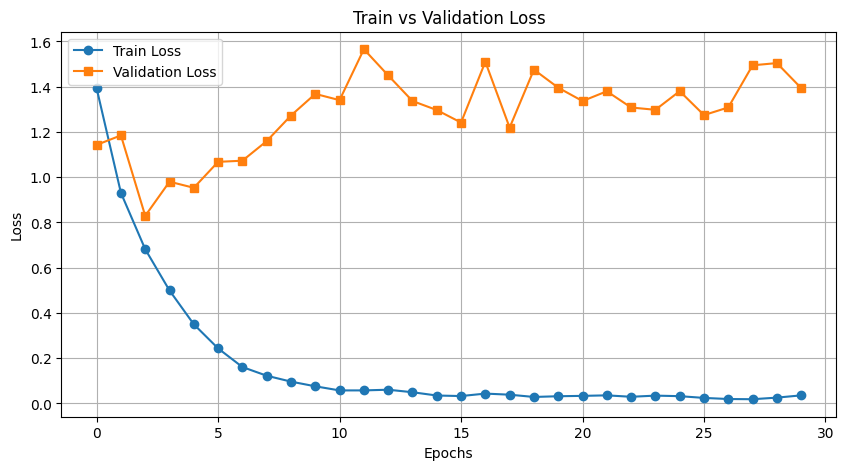

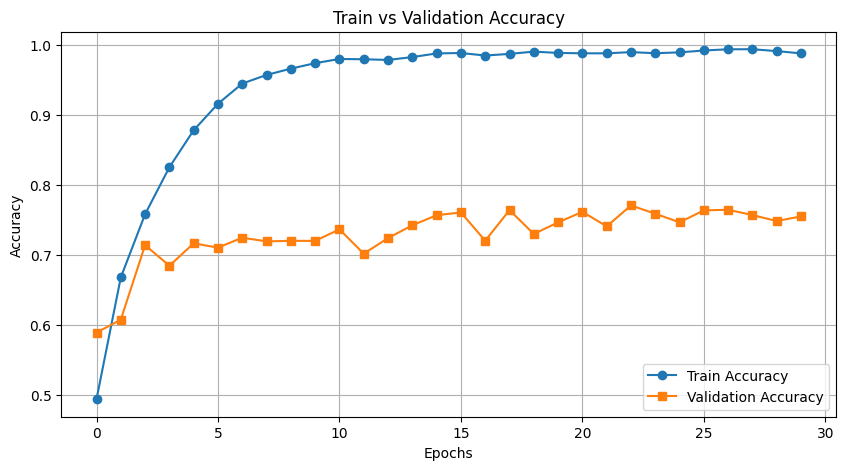

In [11]:
epochs = list(range(30))
train_loss = [1.3930, 0.9308, 0.6817, 0.4993, 0.3498, 0.2432, 0.1609, 0.1225, 0.0964, 0.0757,
              0.0575, 0.0576, 0.0606, 0.0495, 0.0350, 0.0326, 0.0435, 0.0386, 0.0286, 0.0318,
              0.0334, 0.0357, 0.0294, 0.0345, 0.0321, 0.0244, 0.0195, 0.0186, 0.0257, 0.0356]
train_acc = [0.4943, 0.6681, 0.7583, 0.8253, 0.8781, 0.9159, 0.9447, 0.9570, 0.9660, 0.9738,
             0.9798, 0.9794, 0.9784, 0.9825, 0.9877, 0.9883, 0.9847, 0.9870, 0.9903, 0.9884,
             0.9879, 0.9878, 0.9896, 0.9880, 0.9892, 0.9919, 0.9936, 0.9937, 0.9910, 0.9878]
val_loss = [1.1428, 1.1848, 0.8292, 0.9801, 0.9532, 1.0679, 1.0729, 1.1595, 1.2727, 1.3682,
            1.3406, 1.5657, 1.4500, 1.3368, 1.2969, 1.2416, 1.5101, 1.2192, 1.4755, 1.3956,
            1.3366, 1.3798, 1.3081, 1.2979, 1.3803, 1.2746, 1.3084, 1.4946, 1.5044, 1.3940]
val_acc = [0.5894, 0.6078, 0.7142, 0.6847, 0.7167, 0.7106, 0.7248, 0.7195, 0.7203, 0.7202,
           0.7367, 0.7020, 0.7242, 0.7425, 0.7569, 0.7608, 0.7205, 0.7641, 0.7301, 0.7466,
           0.7617, 0.7410, 0.7708, 0.7590, 0.7467, 0.7638, 0.7646, 0.7571, 0.7485, 0.7552]


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def modify_pretrained_model_mod4(model):
    in_channels = model.conv1.in_channels
    out_channels = model.conv1.out_channels
    new_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    nn.init.kaiming_normal_(new_conv1.weight, mode='fan_out', nonlinearity='relu')
    model.conv1 = new_conv1
    downsample = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
    nn.init.kaiming_normal_(downsample.weight, mode='fan_out', nonlinearity='relu')
    model.maxpool = downsample
    return model

pretrained_mod4 = models.resnet18(pretrained=True)
pretrained_mod4.fc = nn.Linear(pretrained_mod4.fc.in_features, num_classes)
pretrained_mod4 = modify_pretrained_model_mod4(pretrained_mod4)
# pretrained_mod4 = pretrained_mod4.to("mps")
pretrained_mod4 = pretrained_mod4.to("cuda")
wandb.init(project="custom-resnet-36-pretrained-mod4", entity="aryan-g")
pretrained_mod4 = train_model(pretrained_mod4, train_loader, test_loader, num_epochs=30)
torch.save(pretrained_mod4.state_dict(), "custom-resnet-36-pretrained-mod4.pth")

/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0: train loss 0.9813, train acc 0.6522, val loss 0.8687, val acc 0.7084
Epoch 1: train loss 0.5305, train acc 0.8166, val loss 0.6486, val acc 0.7788
Epoch 2: train loss 0.3489, train acc 0.8802, val loss 0.6965, val acc 0.7834
Epoch 3: train loss 0.2345, train acc 0.9191, val loss 0.6611, val acc 0.8041
Epoch 4: train loss 0.1681, train acc 0.9414, val loss 0.7740, val acc 0.7906
Epoch 5: train loss 0.1190, train acc 0.9591, val loss 0.9789, val acc 0.7665
Epoch 6: train loss 0.0934, train acc 0.9678, val loss 0.7385, val acc 0.8146
Epoch 7: train loss 0.0728, train acc 0.9747, val loss 0.7149, val acc 0.8234
Epoch 8: train loss 0.0641, train acc 0.9779, val loss 0.8167, val acc 0.8125
Epoch 9: train loss 0.0511, train acc 0.9825, val loss 0.8237, val acc 0.8204
Epoch 10: train loss 0.0491, train acc 0.9829, val loss 0.7751, val acc 0.8337
Epoch 11: train loss 0.0407, train acc 0.9863, val loss 0.8806, val acc 0.8174
Epoch 12: train loss 0.0419, train acc 0.9859, val loss 0.8588

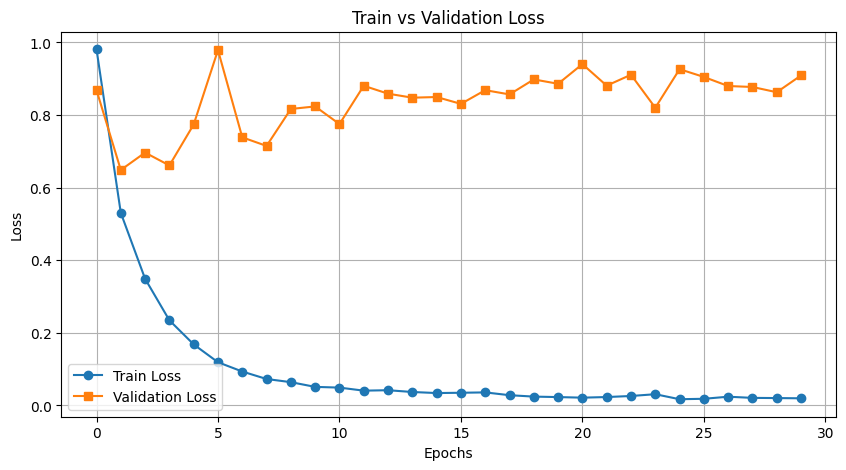

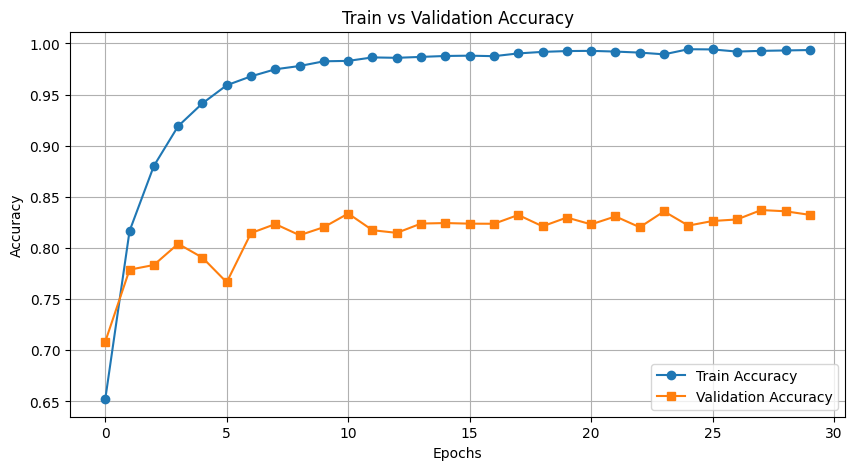

In [12]:
epochs = list(range(30))
train_loss = [0.9813, 0.5305, 0.3489, 0.2345, 0.1681, 0.1190, 0.0934, 0.0728, 0.0641, 0.0511,
              0.0491, 0.0407, 0.0419, 0.0370, 0.0341, 0.0349, 0.0359, 0.0282, 0.0243, 0.0230,
              0.0214, 0.0231, 0.0260, 0.0309, 0.0171, 0.0183, 0.0240, 0.0208, 0.0203, 0.0196]
train_acc = [0.6522, 0.8166, 0.8802, 0.9191, 0.9414, 0.9591, 0.9678, 0.9747, 0.9779, 0.9825,
             0.9829, 0.9863, 0.9859, 0.9868, 0.9877, 0.9880, 0.9875, 0.9902, 0.9917, 0.9925,
             0.9927, 0.9920, 0.9910, 0.9893, 0.9943, 0.9941, 0.9920, 0.9927, 0.9931, 0.9935]
val_loss = [0.8687, 0.6486, 0.6965, 0.6611, 0.7740, 0.9789, 0.7385, 0.7149, 0.8167, 0.8237,
            0.7751, 0.8806, 0.8588, 0.8478, 0.8496, 0.8307, 0.8685, 0.8568, 0.8981, 0.8861,
            0.9403, 0.8809, 0.9110, 0.8201, 0.9263, 0.9049, 0.8799, 0.8773, 0.8628, 0.9091]
val_acc = [0.7084, 0.7788, 0.7834, 0.8041, 0.7906, 0.7665, 0.8146, 0.8234, 0.8125, 0.8204,
           0.8337, 0.8174, 0.8148, 0.8239, 0.8244, 0.8238, 0.8237, 0.8323, 0.8212, 0.8298,
           0.8231, 0.8309, 0.8203, 0.8358, 0.8219, 0.8264, 0.8279, 0.8371, 0.8359, 0.8324]


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Comparative Analysis of Modified ResNet18 Architectures for 36×36 Images

The standard ResNet18 architecture was originally designed for large (224×224) images. When applied to a custom dataset with 36×36 images, the standard first convolutional layer (7×7 kernel with stride 2) and subsequent max pooling reduce the spatial dimensions too aggressively (e.g., from 36×36 to roughly 9×9) so that much of the image’s spatial detail is lost. Two potential remedies are:

1. **Resizing the images to 224×224.**  
   *Pros:* Retains more detail in the early layers.  
   *Cons:* Much higher compute cost (e.g., 10 minutes vs. 2 hours per run) and increased VRAM usage. Moreover, interpolating up does not add new information.

2. **Modifying the architecture’s initial layers.**  
   The goal is to better preserve spatial details without resorting to costly upsampling. In our experiments, we modified the first convolutional layer (`conv1`) and the pooling operation in several ways. We applied each modification to both models trained from scratch and models initialized from pretrained ImageNet weights (with the first layer re‐initialized as needed).

In the sections below, we describe at least four different modifications, compare their performance, and discuss the effects of factors such as kernel size, use of pooling, and the role of pretrained weights.

---

## 1. Architectural Modifications

### Modification 1: Reduced Kernel Size & Removed Max Pooling
- **What was done:**  
  - Change `conv1` from a 7×7 kernel with stride 2 to a 3×3 kernel with stride 1.
  - Replace the max pooling layer with an identity function (i.e., remove it).
- **Rationale:**  
  - A smaller kernel and no pooling preserve more of the spatial resolution of a 36×36 input.
- **Results:**  
  - **From-Scratch Model:**  
    - Final Training Accuracy: ~99.3%  
    - Final Validation Accuracy: ~80.0%
  - **Pretrained Model:**  
    - Final Training Accuracy: ~99.8%  
    - Final Validation Accuracy: ~90.4%

### Modification 2: Increased Kernel Size with Retained Max Pooling
- **What was done:**  
  - Change `conv1` to use a 5×5 kernel with stride 1.
  - *Do not* remove the max pooling layer.
- **Rationale:**  
  - A larger kernel may capture more context, but retaining pooling may still reduce spatial dimensions rapidly.
- **Results:**  
  - **From-Scratch Model:**  
    - Final Training Accuracy: ~98.9%  
    - Final Validation Accuracy: ~77.1%
  - **Pretrained Model:**  
    - Final Training Accuracy: ~99.8%  
    - Final Validation Accuracy: ~90.4%
- **Observations:**  
  - Compared to Mod1, the additional pooling in Mod2 appears to hurt performance on small images, especially in the from‐scratch model.

### Modification 3: Two-Stage Convolutional Block (Double 3×3 Convs) & Removed Max Pooling
- **What was done:**  
  - Replace the single `conv1` layer with a block of two consecutive 3×3 convolutional layers (each followed by BatchNorm and ReLU).
  - Remove max pooling.
- **Rationale:**  
  - The two-layer block can extract more complex features while still preserving spatial resolution.
- **Results:**  
  - **From-Scratch Model:**  
    - Final Training Accuracy: ~99.3%  
    - Final Validation Accuracy: ~81.5%
  - **Pretrained Model:**  
    - Final Training Accuracy: ~99.7–99.8%  
    - Final Validation Accuracy: ~89.0%
- **Observations:**  
  - The extra nonlinearity and feature extraction in the double conv block slightly improves validation accuracy over Mod1 for the from‐scratch model.

### Modification 4: Learned Downsampling in Place of Max Pooling
- **What was done:**  
  - Replace the standard max pooling with a convolutional layer (3×3 kernel, stride 2) for downsampling.
  - Keep `conv1` as a 3×3 layer with stride 1.
- **Rationale:**  
  - A learned downsampling operation may allow the network to control how spatial information is reduced, rather than a fixed max pooling.
- **Results:**  
  - **From-Scratch Model:**  
    - Final Training Accuracy: ~98.8%  
    - Final Validation Accuracy: ~75.5%
  - **Pretrained Model:**  
    - Final Training Accuracy: ~99.3%  
    - Final Validation Accuracy: ~83.2%
- **Observations:**  
  - Although the learned downsampling allows the network to potentially adapt better than fixed pooling, in our experiments Mod4 underperformed compared to Mod1 and Mod3.

---

## 2. Comparisons and Discussion

### Pretrained vs. From-Scratch
- **Pretrained Models:**  
  - In every modification, the models with ImageNet pretrained weights (with only the first layer re-initialized) consistently reached higher validation accuracies and often converged faster.
  - **Key Point:** Although the first layer is initialized from scratch (using, for example, Kaiming initialization) while the remaining layers use pretrained weights, the mismatch in weight distributions does **not** significantly hurt performance. The pretrained layers provide robust feature extraction, and the network quickly learns a good representation in the newly initialized first layer.
- **From-Scratch Models:**  
  - These models typically show lower final accuracies, especially on validation, likely due to limited data and the challenge of learning low-level features from a small input resolution.

### Effects of Kernel Size and Pooling
- **Kernel Size:**  
  - Reducing the kernel size from 7×7 to 3×3 (as in Mod1 and Mod3) is critical when dealing with 36×36 images. It helps preserve spatial dimensions in the early layers.
  - Increasing the kernel size to 5×5 (Mod2) can capture more local context but may come at the cost of a larger receptive field than necessary for such small images, especially when combined with pooling.
- **Pooling:**  
  - Removing or replacing max pooling is important to avoid an overly rapid reduction in spatial resolution.  
  - **Modifications without pooling (Mod1 and Mod3)** generally performed better than those with standard pooling (Mod2) or a learned downsampling (Mod4), indicating that preserving spatial detail is vital for such small inputs.

### Impact on Training Dynamics
- **Loss and Accuracy Trends:**  
  - All modifications reached near-perfect training accuracy by the end of 30 epochs, but validation performance varied significantly.
  - Modifications that better preserve spatial resolution (Mod1 and Mod3) lead to lower validation losses and higher validation accuracies.
- **Compute Considerations:**  
  - Although resizing images to 224×224 can improve performance by providing richer details, it comes at the cost of substantially increased computation time (from minutes to hours) and VRAM usage.
  - Architectural modifications allow us to better tailor the network for small images without incurring this additional cost.

---

## 3. Conclusions

- **Architectural Tweaks Matter:**  
  - Modifying the initial layers of ResNet18 to use smaller kernels and to remove or adapt pooling operations significantly improves the performance on 36×36 images.
  - Among the tested modifications, **Mod1 (3×3 kernel with stride 1 and removal of max pooling)** and **Mod3 (double 3×3 convolutional block without pooling)** produced the best validation accuracies.
  
- **Pretrained Weights Provide a Strong Advantage:**  
  - The models that leveraged pretrained ImageNet weights (with the first layer reinitialized) consistently outperformed the models trained from scratch.  
  - The difference in initialization distribution between the first layer and later layers does not appear to hinder the training process significantly.

- **Balancing Detail with Efficiency:**  
  - While increasing input image size (e.g., to 224×224) would preserve more detail, it is computationally expensive. The modifications described offer a computationally efficient alternative by adapting the architecture to better handle low-resolution inputs.

##  Pretrained model, the first layer needs to be initialized from scratch

While it might seem concerning at first that the first layer is initialized from scratch while the rest of the network uses pretrained weights (and thus different initial distributions), in practice this does not tend to adversely affect training in a significant way:

1. **Rapid Adaptation of the First Layer:**  
   The first layer quickly learns to adapt to the new input distribution. Even though it starts with a random initialization (typically using a well-established scheme like Kaiming initialization), the optimization process updates its weights rapidly based on the loss signal. This adaptation typically happens in the early epochs of fine-tuning.

2. **Robust Feature Extraction in Deeper Layers:**  
   The pretrained weights in the subsequent layers capture high-level features that are often transferable across tasks. These layers provide a strong and stable representation, which helps guide the learning of the newly initialized first layer. As a result, any initial mismatch in distributions is quickly compensated for by the pretrained layers.

3. **Empirical Evidence:**  
   In practice, many transfer learning applications reinitialize the first layer (or other layers) when adapting to different input modalities or resolutions. Empirical results have shown that this strategy does not significantly hurt performance; the network usually converges well and achieves competitive accuracy.

4. **Optimization and Learning Rate Strategies:**  
   Fine-tuning is often performed with a reduced learning rate, especially for the pretrained layers, while the newly initialized layers may have a slightly higher rate. This careful balancing further ensures that the network as a whole learns harmoniously, minimizing any adverse effects due to differences in weight initialization.

**Conclusion:**  
The different initialization distributions between the first layer and the rest of the pretrained network typically do not make the model learn worse. The network is capable of adapting during fine-tuning, and the benefits of having pretrained higher-level features generally outweigh any initial discrepancies in the first layer's weights.


Using device: mps

Evaluating model weights from file: custom-resnet-36-mod1.pth


/var/folders/vm/wmkh255j12x_ylgv2g4ltlhr0000gn/T/ipykernel_81209/1274297213.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file, map_location=d

Weighted F1 Score: 0.8013
Confusion Matrix:
[[863   6  23  38   9   0  10  20  25   6]
 [ 15 882   1  10   2   1  28   9  12  40]
 [ 54   2 679  88  36  21  69  48   1   2]
 [ 12   0  48 751  20  66  59  38   2   4]
 [ 11   1  45  70 714  27  36  93   3   0]
 [  5   0  34 229  20 609  35  66   1   1]
 [ 10   0  24  43  14   5 896   7   1   0]
 [ 11   0   8  38  11   8   2 922   0   0]
 [ 46  14   7  23   1   1  12   3 885   8]
 [ 38  48   4  19   0   0  28  38  20 805]]


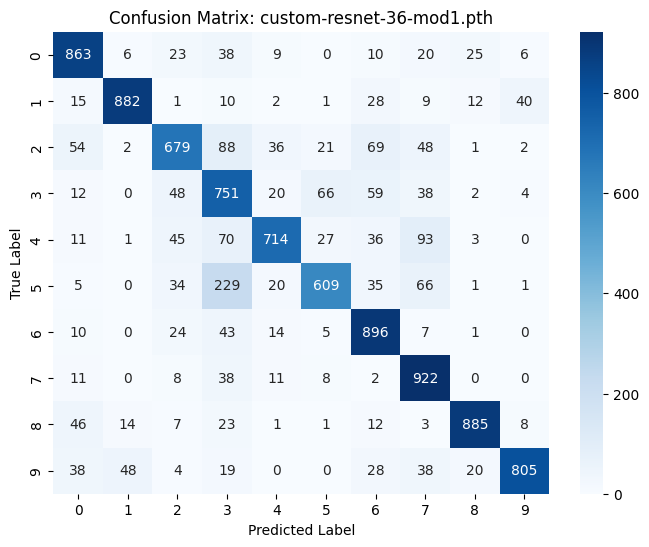


Evaluating model weights from file: custom-resnet-36-mod2.pth


/opt/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/vm/wmkh255j12x_ylgv2g4ltlhr0000gn/T/ipykernel_81209/1274297213.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value f

Weighted F1 Score: 0.7691
Confusion Matrix:
[[848   8  60  14   6   2   6  11  24  21]
 [ 17 923   5   6   0   2   8   7   6  26]
 [ 56   7 764  29  40  40  40  16   1   7]
 [ 27  10  89 572  22 153  85  29   6   7]
 [ 29   4  86  57 629  20  52 119   1   3]
 [ 16   8  66 124  25 656  29  70   2   4]
 [ 12   5  46  24  20  15 868   5   1   4]
 [ 12   3  38  25  14  30   6 865   0   7]
 [ 92  33  27  22   2   3  11  10 777  23]
 [ 40  92  12  13   0   8   4  18  10 803]]


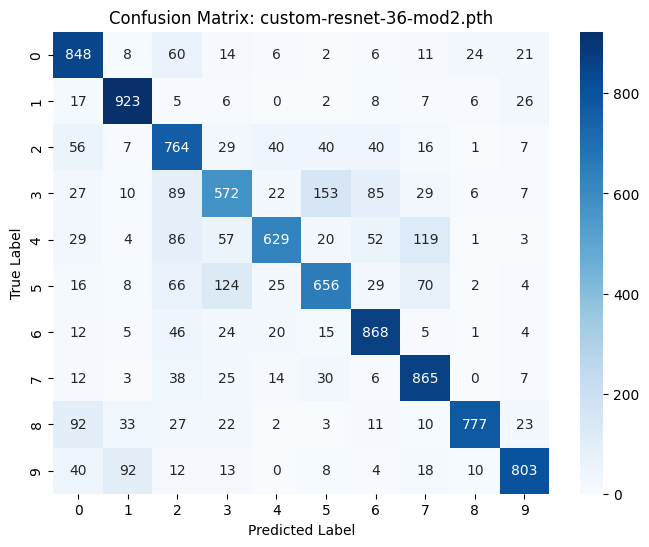


Evaluating model weights from file: custom-resnet-36-mod3.pth


/opt/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/vm/wmkh255j12x_ylgv2g4ltlhr0000gn/T/ipykernel_81209/1274297213.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value f

Weighted F1 Score: 0.8165
Confusion Matrix:
[[856  10  22  17  21   2   5   7  38  22]
 [  7 889   0   4   5   4   4   2  11  74]
 [ 68   3 676  78  94  27  35  11   4   4]
 [ 13   3  44 752  59  67  31  17   7   7]
 [ 10   1  20  67 856  10  14  14   6   2]
 [ 10   4  26 199  51 676  11  17   1   5]
 [  7   2  24  49  46  18 846   3   1   4]
 [ 16   1  15  60  79  22   2 791   2  12]
 [ 43  16   9  11   3   0   5   1 889  23]
 [ 14  29   4  15   1   0   3   5   9 920]]


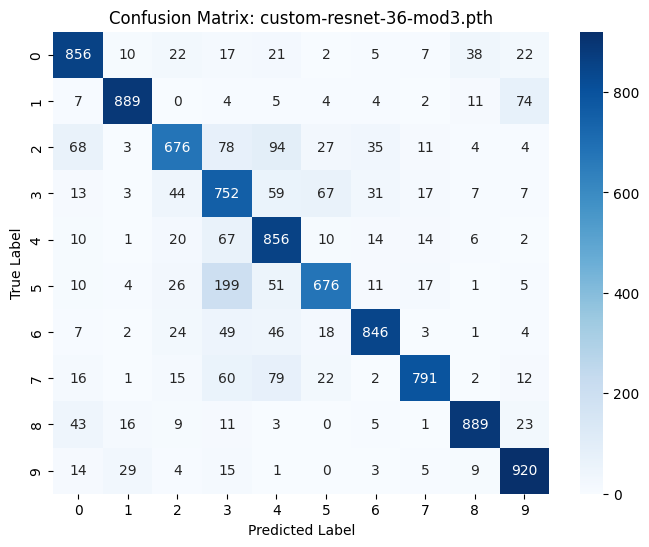


Evaluating model weights from file: custom-resnet-36-mod4.pth


/opt/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/vm/wmkh255j12x_ylgv2g4ltlhr0000gn/T/ipykernel_81209/1274297213.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value f

Weighted F1 Score: 0.7531
Confusion Matrix:
[[820   9  28  25  15   1   5  10  70  17]
 [ 13 896   1   5   2   1   1   4  32  45]
 [ 78   7 606 105  70  12  51  44  19   8]
 [ 24  17  46 642  62  67  53  51  22  16]
 [ 29   2  51  75 703  19  30  75  13   3]
 [ 18   9  59 240  38 521  19  71  14  11]
 [ 10  16  31  68  40   7 788  15  18   7]
 [ 10   2  24  37  34  16   2 860   6   9]
 [ 42  16   6   7   3   0   3   6 908   9]
 [ 37  78  10   9   1   1   1  18  37 808]]


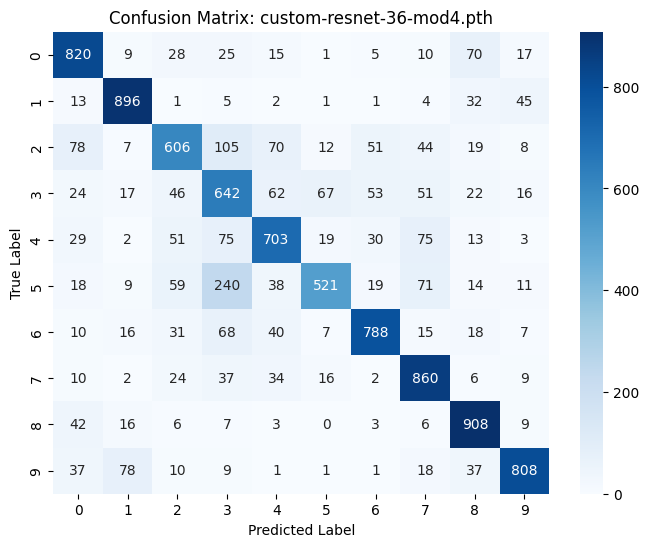

In [6]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def get_model_from_name(file_name, num_classes):
    if "224" in file_name:
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    if "mod2" in file_name:
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        in_channels = model.conv1.in_channels
        out_channels = model.conv1.out_channels
        model.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2, bias=False)
        return model
    elif "mod3" in file_name:
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        in_channels = model.conv1.in_channels
        mid_channels = model.conv1.out_channels
        conv1a = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False)
        conv1b = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False)
        new_conv_block = nn.Sequential(
            conv1a,
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            conv1b,
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )
        model.conv1 = new_conv_block
        model.maxpool = nn.Identity()
        return model
    elif "mod4" in file_name:
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        in_channels = model.conv1.in_channels
        out_channels = model.conv1.out_channels
        model.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        downsample = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
        model.maxpool = downsample
        return model
    elif "mod1" in file_name:
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes) 
        in_channels = model.conv1.in_channels
        out_channels = model.conv1.out_channels
        model.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()
        return model
            # def modify_initial_layers(model, kernel_size=3, stride=1, remove_maxpool=True):
            # in_channels = model.conv1.in_channels
            # out_channels = model.conv1.out_channels
            # model.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
            # model.maxpool = nn.Identity()

    else:
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        in_channels = model.conv1.in_channels
        out_channels = model.conv1.out_channels
        model.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2, bias=False)
        model.maxpool = nn.Identity()
        return model

model_files = [
    "custom-resnet-36-mod1.pth",
    "custom-resnet-36-mod2.pth",
    "custom-resnet-36-mod3.pth",
    "custom-resnet-36-mod4.pth",
]

device = torch.device("mps" if torch.backends.mps.is_available()  else "cuda" if torch.cuda.is_available()  else "cpu")
print("Using device:", device)
num_classes = 10  
for file in model_files:
    print(f"\nEvaluating model weights from file: {file}")
    model = get_model_from_name(file, num_classes)
    state_dict = torch.load(file, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    true_labels, predictions = evaluate_model(model, test_loader, device)
    f1 = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions)

    print(f"Weighted F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, f"Confusion Matrix: {file}")

# Evaluation Summary for Custom ResNet-36 Variants

We evaluated four different modifications of the custom ResNet-36 architecture. Each modification changes the initial layers (i.e. the first convolution and pooling operations) to better suit 36×36 input images. The models were evaluated on a test set and the performance was measured using the weighted F1 score. Below are the results along with the corresponding confusion matrices.

---

## Modifications Overview

- **Mod1:**  
  - **Architecture Change:** The first convolution is modified using a 5×5 kernel (stride=1, padding=2) and the max pooling is removed.
  - **Intuition:** This configuration aims to preserve more spatial information by using a larger kernel and avoiding an aggressive downsampling.

- **Mod2:**  
  - **Architecture Change:** The first convolution uses a 5×5 kernel (stride=1, padding=2) but retains the default max pooling layer.
  - **Intuition:** Keeping the max pool may help in some cases, but it may also reduce the spatial resolution too quickly.

- **Mod3:**  
  - **Architecture Change:** The initial convolution is replaced with a two-layer (double 3×3) block (each followed by BatchNorm and ReLU), with the max pool removed.
  - **Intuition:** The extra convolutional layer adds nonlinearity and more complex feature extraction, which may improve discrimination.

- **Mod4:**  
  - **Architecture Change:** The first convolution uses a 3×3 kernel (stride=1, padding=1) and the max pooling is replaced by a learnable downsampling convolution.
  - **Intuition:** A learnable downsampling layer is expected to adaptively preserve important spatial features; however, it may also introduce additional complexity.

---

## Weighted F1 Scores

| Modification | Weighted F1 Score |
|--------------|-------------------|
| **Mod1**     | 0.8013            |
| **Mod2**     | 0.7691            |
| **Mod3**     | 0.8165            |
| **Mod4**     | 0.7531            |

- **Observations:**
  - **Mod3** achieved the highest F1 score (0.8165), suggesting it most effectively balances precision and recall across classes.
  - **Mod1** is a close second (0.8013).
  - **Mod2** and **Mod4** show lower overall performance, with Mod4 the lowest at 0.7531.

---

## Confusion Matrices

### Mod1
```
[[863   6  23  38   9   0  10  20  25   6]
 [ 15 882   1  10   2   1  28   9  12  40]
 [ 54   2 679  88  36  21  69  48   1   2]
 [ 12   0  48 751  20  66  59  38   2   4]
 [ 11   1  45  70 714  27  36  93   3   0]
 [  5   0  34 229  20 609  35  66   1   1]
 [ 10   0  24  43  14   5 896   7   1   0]
 [ 11   0   8  38  11   8   2 922   0   0]
 [ 46  14   7  23   1   1  12   3 885   8]
 [ 38  48   4  19   0   0  28  38  20 805]]
```

### Mod2
```
[[848   8  60  14   6   2   6  11  24  21]
 [ 17 923   5   6   0   2   8   7   6  26]
 [ 56   7 764  29  40  40  40  16   1   7]
 [ 27  10  89 572  22 153  85  29   6   7]
 [ 29   4  86  57 629  20  52 119   1   3]
 [ 16   8  66 124  25 656  29  70   2   4]
 [ 12   5  46  24  20  15 868   5   1   4]
 [ 12   3  38  25  14  30   6 865   0   7]
 [ 92  33  27  22   2   3  11  10 777  23]
 [ 40  92  12  13   0   8   4  18  10 803]]
```

### Mod3
```
[[856  10  22  17  21   2   5   7  38  22]
 [  7 889   0   4   5   4   4   2  11  74]
 [ 68   3 676  78  94  27  35  11   4   4]
 [ 13   3  44 752  59  67  31  17   7   7]
 [ 10   1  20  67 856  10  14  14   6   2]
 [ 10   4  26 199  51 676  11  17   1   5]
 [  7   2  24  49  46  18 846   3   1   4]
 [ 16   1  15  60  79  22   2 791   2  12]
 [ 43  16   9  11   3   0   5   1 889  23]
 [ 14  29   4  15   1   0   3   5   9 920]]
```

### Mod4
```
[[820   9  28  25  15   1   5  10  70  17]
 [ 13 896   1   5   2   1   1   4  32  45]
 [ 78   7 606 105  70  12  51  44  19   8]
 [ 24  17  46 642  62  67  53  51  22  16]
 [ 29   2  51  75 703  19  30  75  13   3]
 [ 18   9  59 240  38 521  19  71  14  11]
 [ 10  16  31  68  40   7 788  15  18   7]
 [ 10   2  24  37  34  16   2 860   6   9]
 [ 42  16   6   7   3   0   3   6 908   9]
 [ 37  78  10   9   1   1   1  18  37 808]]
```

---

## Analysis

- **Mod1:**  
  - The confusion matrix for Mod1 shows high correct classification counts along the diagonal with moderate misclassifications in a few classes.  
  - **Weighted F1 Score:** 0.8013  
  - **Interpretation:** This variant performs well overall, with particularly strong performance in many classes; however, some classes still suffer from moderate confusion.

- **Mod2:**  
  - The confusion matrix for Mod2 indicates increased misclassifications (e.g., more off-diagonal values) compared to Mod1.  
  - **Weighted F1 Score:** 0.7691  
  - **Interpretation:** Retaining the default max pooling while using a 5×5 kernel appears to reduce performance, likely because the pooling may remove useful spatial details from the small images.

- **Mod3:**  
  - Mod3’s confusion matrix shows improved class separation, with high diagonal values and fewer misclassifications overall.  
  - **Weighted F1 Score:** 0.8165  
  - **Interpretation:** The double 3×3 convolution block (without pooling) provides the best performance among the modifications, likely by better preserving and extracting detailed spatial features.

- **Mod4:**  
  - The confusion matrix for Mod4 reveals a higher degree of misclassification across classes.  
  - **Weighted F1 Score:** 0.7531  
  - **Interpretation:** Replacing max pooling with a learnable downsampling layer did not work as well for this dataset, possibly due to insufficient ability to retain critical spatial information compared to the simpler removal of pooling.

## Conclusion

- **Best Performing Variant:**  
  **Mod3** achieved the highest weighted F1 score (0.8165) and the clearest class separation in the confusion matrix, suggesting that a double 3×3 convolution block without pooling is most effective for this custom 36×36 dataset.

- **Good Alternative:**  
  **Mod1** also performed well (F1 = 0.8013), indicating that using a 5×5 conv1 with no pooling is a viable option.

- **Less Effective Variants:**  
  **Mod2** and **Mod4** show lower performance (F1 = 0.7691 and 0.7531, respectively), implying that retaining the default pooling or replacing it with a learnable layer may not be optimal for preserving spatial detail in such small images.


## Why Do These Differences Arise?

The observed differences in weighted F1 scores and the structure of the confusion matrices across the four modifications can be attributed to how each architecture handles spatial information, receptive fields, and nonlinear feature extraction for very low-resolution (36×36) images. Here are the key factors:

1. **Preservation of Spatial Resolution**  
   - **Pooling Effects:**  
     Pooling operations (like max pooling) reduce the spatial dimensions of the feature maps. For very small images, this aggressive downsampling can lead to a loss of critical spatial details.  
     - **Mod1 and Mod3:** Both variants remove pooling, thereby preserving more spatial details that are essential for accurate classification.
     - **Mod2:** Retains the default pooling, which likely removes too much spatial information early in the network.
     - **Mod4:** Replaces fixed pooling with a learnable downsampling convolution. While this introduces flexibility, it may not preserve spatial details as robustly as simply removing pooling.

2. **Kernel Size and Receptive Field**  
   - **Larger vs. Stacked Convolutions:**  
     A single convolution with a larger kernel (e.g., 5×5) covers a broader receptive field compared to a 3×3 convolution. However, stacking two 3×3 convolutions can approximate a 5×5 receptive field while also introducing additional nonlinearities.
     - **Mod1:** Uses a single 5×5 convolution (with appropriate padding) in the first layer. This increases the receptive field but only applies one nonlinearity.
     - **Mod3:** Replaces the initial convolution with two sequential 3×3 convolutions. This not only provides an effective receptive field similar to a 5×5 convolution but also introduces extra nonlinearity and feature abstraction. This additional complexity likely contributes to its slightly higher F1 score.
   
3. **Learned Downsampling vs. Fixed Operations**  
   - **Adaptability of Downsampling:**  
     - **Mod4:** Uses a learnable downsampling convolution instead of a fixed max pooling layer. In theory, a learnable layer can adapt to the data better; however, for a small dataset or small image size, the additional parameters and flexibility may lead to suboptimal training or even overfitting, resulting in lower performance.
     - **Mod1 and Mod3:** The simpler strategy of removing pooling entirely appears to be more robust in this context.

4. **Trade-Off Between Complexity and Robustness**  
   - **Mod2 and Mod4** seem to introduce more complexity (either by retaining pooling or by replacing it with a learned layer) but do not provide enough benefit to overcome the loss of spatial detail. In contrast, **Mod3** strikes a good balance by enriching the feature representation (via a double 3×3 block) while still maintaining high spatial resolution.

---

### Summary of Differences

- **Mod1 (5×5 conv1, no pooling):**  
  Preserves spatial detail with a larger kernel; performs well but might be limited by a single nonlinearity.

- **Mod2 (5×5 conv1, with pooling):**  
  Retains the larger kernel but the pooling reduces spatial detail too aggressively, resulting in lower performance.

- **Mod3 (double 3×3 conv block, no pooling):**  
  Combines the benefits of an effective 5×5 receptive field with additional nonlinearity, leading to the best performance overall.

- **Mod4 (3×3 conv1, learned downsampling):**  
  Attempts to learn downsampling instead of using fixed pooling, but this approach seems less robust for small images, leading to the lowest performance.